In [1]:
#matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from dataset.dataloader import *
import operators as ops
import torch
import os

CKPT_DIR = "./logs/checkpoints"
LOAD_PRETRAINED = True

In [2]:
import torch.nn as nn
import torch

class torch_VGG8(nn.Module):
    def __init__(self):
        super(torch_VGG8, self,).__init__()
        # Layer 1 (B, 1, 28, 28) -> (B, 32, 28, 28)
        self.Layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 2 (B, 32, 28, 28) -> (B, 64, 14, 14)
        self.Layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Layer 3 (B, 64, 14, 14) -> (B, 64, 14, 14)
        self.Layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 4 (B, 64, 14, 14) -> (B, 128, 7, 7)
        self.Layer4 =nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Layer 5 (B, 128, 7, 7) -> (B, 256, 7, 7)
        self.Layer5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 6 (B, 256, 7, 7) -> (B, 256, 7, 7)
        self.Layer6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 7 (B, 256*7*7) -> (B, 256)
        self.Layer7 = nn.Sequential(
            nn.Linear(in_features=256*7*7, out_features=256, bias=True,),
            nn.ReLU(True)
        )
        # Layer 8 (B, 256) -> (B, 10)
        self.Layer8 = nn.Sequential(
            nn.Linear(in_features=256, out_features=10, bias=True,),
        )

    def forward(self, x):
        # L1~L6: Conv + ReLU + (MaxPool)
        x = self.Layer1(x)
        x = self.Layer2(x)
        x = self.Layer3(x)
        x = self.Layer4(x)
        x = self.Layer5(x)
        x = self.Layer6(x)
        # L7: FC + ReLU
        x = x.view(x.size(0), -1)
        x = self.Layer7(x)
        # L8: FC
        x = self.Layer8(x)
        return x


In [3]:
class VGG8:
    def __init__(self):
        self.criterion = ops.SoftmaxWithLoss()
        self.conv_layers = [
            # Layer 1 (B, 1, 28, 28) -> (B, 32, 28, 28)
            ops.Conv2D(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1, name="L1_C"),
            ops.ReLU(name="L1_R"),

            # Layer2 (B, 32, 28, 28) -> (B, 64, 14, 14)
            ops.Conv2D(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1, name="L2_C"),
            ops.ReLU(name="L2_R"),
            ops.MaxPooling(kernel_size=2, stride=2, name="L2_M"),
            
            # Layer 3 (B, 64, 14, 14) -> (B, 64, 14, 14)
            ops.Conv2D(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1, name="L3_C"),
            ops.ReLU(name="L3_R"),

            # Layer 4 (B, 64, 14, 14) -> (B, 128, 7, 7)
            ops.Conv2D(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1, name="L4_C"),
            ops.ReLU(name="L4_R"),
            ops.MaxPooling(kernel_size=2, stride=2, name="L4_M"),

            # Layer 5 (B, 128, 7, 7) -> (B, 256, 7, 7)
            ops.Conv2D(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1, name="L5_C"),
            ops.ReLU(name="L5_R"),

            # Layer 6 (B, 256, 7, 7) -> (B, 256, 7, 7)
            ops.Conv2D(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1, name="L6_C"),
            ops.ReLU(name="L6_R")
        ]

        # Layer 7 (B, 256*7*7) -> (B, 256)
        self.fc_layers = [
            ops.FullyConnected(in_feature=256*7*7, out_feature=256, name="L7_FC"),
            ops.ReLU(name="L7_R"),

        # Layer 8 (B, 256) -> (B, 10)
            ops.FullyConnected(in_feature=256, out_feature=10, name="L8_FC")
        ]

    def backprop(self, lr, m=None) -> None:
        # Backward
        #dout = self.criterion.backward(pred, label)
        dout = self.criterion.backward()
        for i in range(len(self.fc_layers)-1, -1, -1):
            dout = self.fc_layers[i].backward(dout)
        dout = dout.reshape(dout.shape[0], 256, 7, 7)
        for i in range(len(self.conv_layers)-1, -1, -1):
            dout = self.conv_layers[i].backward(dout)
        # Update
        for layer in self.conv_layers:
            layer.update(lr, m)
        for layer in self.fc_layers:
            layer.update(lr, m)
        return dout

    def forward(self, x: np.ndarray):
        i = 0
        for layer in self.conv_layers:
            i+=1
            x = layer.forward(x) 
        x = x.reshape(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer.forward(x)
        return x

    def save(self, fileName: str):
        with open(fileName, "wb") as f:
            pickle.dump(self, f)

    def load(self, fileName: str):
        with open(fileName, "rb") as f:
            self = pickle.load(f)

In [4]:
model = VGG8()

In [5]:
if LOAD_PRETRAINED:
    # Load pretrained weights from torch
    torch_vgg8 = torch_VGG8()
    torch_vgg8.load_state_dict(torch.load("torch_vgg8.pt", map_location=torch.device('cpu')))

    for i, p in enumerate(torch_vgg8.Layer1.parameters()):
        if (i == 0):
            print(f"Load L1 Weight:({p.shape},{model.conv_layers[0].W.shape})")
            model.conv_layers[0].W = p.detach().numpy()
        else:
            print(f"Load L1 Bias({model.conv_layers[0].b.shape},{p.shape})")
            model.conv_layers[0].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer2.parameters()):
        print(torch_vgg8.Layer2)
        if (i == 0):
            print(f"Load L2 Weight:({p.shape},{model.conv_layers[2].W.shape})")
            model.conv_layers[2].W = p.detach().numpy()
        else:
            print(f"Load L2 Bias({model.conv_layers[2].b.shape},{p.shape})")
            model.conv_layers[2].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer3.parameters()):
        if (i == 0):
            print(f"Load L3 Weight:({p.shape},{model.conv_layers[5].W.shape})")
            model.conv_layers[5].W = p.detach().numpy()
        else:
            print(f"Load L3 Bias({model.conv_layers[5].b.shape},{p.shape})")
            model.conv_layers[5].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer4.parameters()):
        if (i == 0):
            print(f"Load L4 Weight:({p.shape},{model.conv_layers[7].W.shape})")
            model.conv_layers[7].W = p.detach().numpy()
        else:
            print(f"Load L4 Bias({model.conv_layers[7].b.shape},{p.shape})")
            model.conv_layers[7].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer5.parameters()):
        if (i == 0):
            print(f"Load L5 Weight:({p.shape},{model.conv_layers[10].W.shape})")
            model.conv_layers[10].W = p.detach().numpy()
        else:
            print(f"Load L5 Bias({model.conv_layers[10].b.shape},{p.shape})")
            model.conv_layers[10].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer6.parameters()):
        if (i == 0):
            print(f"Load L6 Weight:({p.shape},{model.conv_layers[12].W.shape})")
            model.conv_layers[12].W = p.detach().numpy()
        else:
            print(f"Load L6 Bias({model.conv_layers[12].b.shape},{p.shape})")
            model.conv_layers[12].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer7.parameters()):
        if (i == 0):
            print(f"Load L7 Weight:({p.shape},{model.fc_layers[0].W.shape})")
            model.fc_layers[0].W = p.T.detach().numpy()
        else:
            print(f"Load L7 Bias({model.fc_layers[0].b.shape},{p.shape})")
            model.fc_layers[0].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer8.parameters()):
        if (i == 0):
            print(f"Load L8 Weight:({p.shape},{model.fc_layers[2].W.shape})")
            model.fc_layers[2].W = p.T.detach().numpy()
        else:
            print(f"Load L8 Bias({model.fc_layers[2].b.shape},{p.shape})")
            model.fc_layers[2].b = p.detach().numpy()

Load L1 Weight:(torch.Size([32, 1, 3, 3]),(32, 1, 3, 3))
Load L1 Bias((32,),torch.Size([32]))
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Load L2 Weight:(torch.Size([64, 32, 3, 3]),(64, 32, 3, 3))
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Load L2 Bias((64,),torch.Size([64]))
Load L3 Weight:(torch.Size([64, 64, 3, 3]),(64, 64, 3, 3))
Load L3 Bias((64,),torch.Size([64]))
Load L4 Weight:(torch.Size([128, 64, 3, 3]),(128, 64, 3, 3))
Load L4 Bias((128,),torch.Size([128]))
Load L5 Weight:(torch.Size([256, 128, 3, 3]),(256, 128, 3, 3))
Load L5 Bias((256,),torch.Size([256]))
Load L6 Weight:(torch.Size([256, 256, 3, 3]),(256, 256, 3, 3))
Load L6 Bias((256,),torch.Size([256]))
Load L7 Weight:(torc

In [6]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

batch_size = 50
learning_rate = 0.01
#momentum = 0.9
momentum = None     # Not use momentum
loss_print_time = 5
accuracy_print_time = loss_print_time * 5
x_log = []
loss_log = []

print(f"Train:{x_train.shape}, Test:{x_test.shape}")

def accuracy_check(model, x_test, t_test, test_size):
    total_correct = 0

    test_data_idx = np.random.choice(x_test.shape[0], test_size)
    for i in tqdm(test_data_idx):
        x = x_test[i].reshape(1, 1, 28, 28)
        labels = t_test[i]

        outputs = model.forward(x)
        pred = ops.Softmax(outputs)
        labels = labels.reshape(pred.shape)
        c = (np.argmax(labels, 1) == np.argmax(pred, 1)).squeeze()
        total_correct += np.sum(c)
    return total_correct/test_size
    #print(f"Accuracy:{total_correct/test_size}")


Train:(60000, 784), Test:(10000, 784)


In [7]:
for epoch in range(10):
    accuracy = 0.0
    train_size = x_train.shape[0]
    running_loss = []
    for i, b in tqdm(enumerate(range(0, train_size, batch_size))):
        x = x_train[b:b+batch_size].reshape(batch_size, 1, 28, 28)   # B, C, H, W
        labels = t_train[b:b+batch_size]
        #optimizer.zero_grad()

        outputs = model.forward(x)
        loss = model.criterion.forward(outputs, labels)
        running_loss.append(loss)
        model.backprop(learning_rate, momentum)

        if (i % loss_print_time == 0):
            if (i % accuracy_print_time == 0):
                print(f'[epoch:{epoch}, data num:{b}] Avg Loss: {sum(running_loss)/len(running_loss):.6f}, Max Loss: {max(running_loss):.6f}, Min Loss: {min(running_loss):.6f}, Accuracy: {accuracy_check(model, x_test, t_test, 100)}')
            else:
                print(f'[epoch:{epoch}, data num:{b}] Avg Loss: {sum(running_loss)/len(running_loss):.6f}, Max Loss: {max(running_loss):.6f}, Min Loss: {min(running_loss):.6f}')
            loss_log += running_loss
            running_loss = []
            #model.save(os.path.join(CKPT_DIR, "epoch_%03d_%06d.pkl" % (epoch, i) ))




100%|██████████| 100/100 [00:00<00:00, 102.88it/s]
1it [00:02,  2.07s/it]

[epoch:0, data num:0] Avg Loss: 2.200621, Max Loss: 2.200621, Min Loss: 2.200621, Accuracy: 0.4


6it [00:06,  1.09it/s]

[epoch:0, data num:250] Avg Loss: 2.174982, Max Loss: 2.197398, Min Loss: 2.157605


11it [00:10,  1.15it/s]

[epoch:0, data num:500] Avg Loss: 2.182700, Max Loss: 2.213145, Min Loss: 2.148148


16it [00:15,  1.13it/s]

[epoch:0, data num:750] Avg Loss: 2.180271, Max Loss: 2.206374, Min Loss: 2.160433


21it [00:19,  1.15it/s]

[epoch:0, data num:1000] Avg Loss: 2.165117, Max Loss: 2.190412, Min Loss: 2.132191


100%|██████████| 100/100 [00:00<00:00, 104.89it/s]
26it [00:24,  1.16s/it]

[epoch:0, data num:1250] Avg Loss: 2.154774, Max Loss: 2.178883, Min Loss: 2.122019, Accuracy: 0.56


31it [00:29,  1.07it/s]

[epoch:0, data num:1500] Avg Loss: 2.121231, Max Loss: 2.153567, Min Loss: 2.095498


36it [00:33,  1.11it/s]

[epoch:0, data num:1750] Avg Loss: 2.067081, Max Loss: 2.132733, Min Loss: 1.994248


41it [00:38,  1.12it/s]

[epoch:0, data num:2000] Avg Loss: 2.039867, Max Loss: 2.063726, Min Loss: 2.005701


46it [00:42,  1.15it/s]

[epoch:0, data num:2250] Avg Loss: 1.965655, Max Loss: 2.010549, Min Loss: 1.922879


100%|██████████| 100/100 [00:00<00:00, 104.00it/s]
51it [00:48,  1.19s/it]

[epoch:0, data num:2500] Avg Loss: 1.922374, Max Loss: 1.964131, Min Loss: 1.876239, Accuracy: 0.49


56it [00:52,  1.08it/s]

[epoch:0, data num:2750] Avg Loss: 1.837250, Max Loss: 1.961504, Min Loss: 1.763421


61it [00:56,  1.15it/s]

[epoch:0, data num:3000] Avg Loss: 1.696707, Max Loss: 1.780714, Min Loss: 1.502171


66it [01:01,  1.12it/s]

[epoch:0, data num:3250] Avg Loss: 1.666554, Max Loss: 1.814787, Min Loss: 1.571664


71it [01:05,  1.14it/s]

[epoch:0, data num:3500] Avg Loss: 1.599296, Max Loss: 1.710672, Min Loss: 1.506258


100%|██████████| 100/100 [00:00<00:00, 103.85it/s]
76it [01:10,  1.18s/it]

[epoch:0, data num:3750] Avg Loss: 1.402063, Max Loss: 1.536974, Min Loss: 1.275563, Accuracy: 0.47


81it [01:15,  1.09it/s]

[epoch:0, data num:4000] Avg Loss: 1.230892, Max Loss: 1.368979, Min Loss: 1.114731


86it [01:19,  1.15it/s]

[epoch:0, data num:4250] Avg Loss: 1.296053, Max Loss: 1.538974, Min Loss: 1.042564


91it [01:24,  1.13it/s]

[epoch:0, data num:4500] Avg Loss: 1.144601, Max Loss: 1.427142, Min Loss: 0.876550


96it [01:28,  1.13it/s]

[epoch:0, data num:4750] Avg Loss: 1.186683, Max Loss: 1.719748, Min Loss: 0.805727


100%|██████████| 100/100 [00:00<00:00, 103.03it/s]
101it [01:33,  1.18s/it]

[epoch:0, data num:5000] Avg Loss: 1.065991, Max Loss: 1.331613, Min Loss: 0.909946, Accuracy: 0.7


106it [01:38,  1.07it/s]

[epoch:0, data num:5250] Avg Loss: 1.021936, Max Loss: 1.131255, Min Loss: 0.925650


111it [01:42,  1.13it/s]

[epoch:0, data num:5500] Avg Loss: 0.947470, Max Loss: 1.240086, Min Loss: 0.725806


116it [01:47,  1.15it/s]

[epoch:0, data num:5750] Avg Loss: 1.001385, Max Loss: 1.275617, Min Loss: 0.832665


121it [01:51,  1.14it/s]

[epoch:0, data num:6000] Avg Loss: 0.796487, Max Loss: 0.900822, Min Loss: 0.661676


100%|██████████| 100/100 [00:00<00:00, 103.81it/s]
126it [01:56,  1.18s/it]

[epoch:0, data num:6250] Avg Loss: 0.797602, Max Loss: 1.052737, Min Loss: 0.601343, Accuracy: 0.66


131it [02:01,  1.07it/s]

[epoch:0, data num:6500] Avg Loss: 0.711955, Max Loss: 0.813429, Min Loss: 0.605984


136it [02:05,  1.12it/s]

[epoch:0, data num:6750] Avg Loss: 0.606617, Max Loss: 0.696600, Min Loss: 0.511630


141it [02:10,  1.13it/s]

[epoch:0, data num:7000] Avg Loss: 1.099524, Max Loss: 1.390232, Min Loss: 0.831322


146it [02:14,  1.12it/s]

[epoch:0, data num:7250] Avg Loss: 0.740392, Max Loss: 0.951074, Min Loss: 0.620202


100%|██████████| 100/100 [00:00<00:00, 104.84it/s]
151it [02:20,  1.18s/it]

[epoch:0, data num:7500] Avg Loss: 0.742514, Max Loss: 0.866396, Min Loss: 0.629104, Accuracy: 0.76


156it [02:24,  1.06it/s]

[epoch:0, data num:7750] Avg Loss: 0.720684, Max Loss: 0.866765, Min Loss: 0.437406


161it [02:28,  1.12it/s]

[epoch:0, data num:8000] Avg Loss: 0.816793, Max Loss: 1.179011, Min Loss: 0.631423


166it [02:33,  1.14it/s]

[epoch:0, data num:8250] Avg Loss: 0.683539, Max Loss: 0.926198, Min Loss: 0.413705


171it [02:37,  1.14it/s]

[epoch:0, data num:8500] Avg Loss: 0.777071, Max Loss: 1.026602, Min Loss: 0.465420


100%|██████████| 100/100 [00:00<00:00, 102.47it/s]
176it [02:43,  1.16s/it]

[epoch:0, data num:8750] Avg Loss: 0.740979, Max Loss: 0.988040, Min Loss: 0.515517, Accuracy: 0.71


181it [02:47,  1.07it/s]

[epoch:0, data num:9000] Avg Loss: 0.583407, Max Loss: 1.024977, Min Loss: 0.375691


186it [02:51,  1.13it/s]

[epoch:0, data num:9250] Avg Loss: 0.552816, Max Loss: 0.610242, Min Loss: 0.457221


191it [02:56,  1.11it/s]

[epoch:0, data num:9500] Avg Loss: 0.563704, Max Loss: 0.673554, Min Loss: 0.436615


196it [03:00,  1.13it/s]

[epoch:0, data num:9750] Avg Loss: 0.543908, Max Loss: 0.778709, Min Loss: 0.402546


100%|██████████| 100/100 [00:00<00:00, 101.90it/s]
201it [03:06,  1.20s/it]

[epoch:0, data num:10000] Avg Loss: 0.491667, Max Loss: 0.715709, Min Loss: 0.391365, Accuracy: 0.89


206it [03:11,  1.02s/it]

[epoch:0, data num:10250] Avg Loss: 0.544273, Max Loss: 0.641713, Min Loss: 0.485526


211it [03:15,  1.09it/s]

[epoch:0, data num:10500] Avg Loss: 0.377246, Max Loss: 0.525662, Min Loss: 0.265787


216it [03:19,  1.14it/s]

[epoch:0, data num:10750] Avg Loss: 0.618066, Max Loss: 0.808108, Min Loss: 0.402471


221it [03:24,  1.10it/s]

[epoch:0, data num:11000] Avg Loss: 0.445858, Max Loss: 0.543640, Min Loss: 0.346258


100%|██████████| 100/100 [00:00<00:00, 103.71it/s]
226it [03:29,  1.18s/it]

[epoch:0, data num:11250] Avg Loss: 0.543224, Max Loss: 0.590502, Min Loss: 0.473976, Accuracy: 0.88


231it [03:34,  1.10it/s]

[epoch:0, data num:11500] Avg Loss: 0.412072, Max Loss: 0.603228, Min Loss: 0.313874


236it [03:38,  1.16it/s]

[epoch:0, data num:11750] Avg Loss: 0.672039, Max Loss: 0.977077, Min Loss: 0.458971


241it [03:42,  1.13it/s]

[epoch:0, data num:12000] Avg Loss: 0.421080, Max Loss: 0.511440, Min Loss: 0.345884


246it [03:47,  1.14it/s]

[epoch:0, data num:12250] Avg Loss: 0.456325, Max Loss: 0.600164, Min Loss: 0.228924


100%|██████████| 100/100 [00:00<00:00, 106.73it/s]
251it [03:52,  1.17s/it]

[epoch:0, data num:12500] Avg Loss: 0.665744, Max Loss: 0.741728, Min Loss: 0.558839, Accuracy: 0.84


256it [03:56,  1.09it/s]

[epoch:0, data num:12750] Avg Loss: 0.618912, Max Loss: 0.916505, Min Loss: 0.352339


261it [04:01,  1.09it/s]

[epoch:0, data num:13000] Avg Loss: 0.523261, Max Loss: 0.716329, Min Loss: 0.355984


266it [04:06,  1.04s/it]

[epoch:0, data num:13250] Avg Loss: 0.471097, Max Loss: 0.608551, Min Loss: 0.301584


271it [04:11,  1.07it/s]

[epoch:0, data num:13500] Avg Loss: 0.435601, Max Loss: 0.466720, Min Loss: 0.399001


100%|██████████| 100/100 [00:00<00:00, 102.65it/s]
276it [04:16,  1.22s/it]

[epoch:0, data num:13750] Avg Loss: 0.458589, Max Loss: 0.680787, Min Loss: 0.216750, Accuracy: 0.89


281it [04:21,  1.04it/s]

[epoch:0, data num:14000] Avg Loss: 0.540283, Max Loss: 0.750805, Min Loss: 0.372187


286it [04:26,  1.10it/s]

[epoch:0, data num:14250] Avg Loss: 0.623581, Max Loss: 0.821827, Min Loss: 0.498539


291it [04:30,  1.10it/s]

[epoch:0, data num:14500] Avg Loss: 0.645406, Max Loss: 0.954756, Min Loss: 0.331636


296it [04:34,  1.12it/s]

[epoch:0, data num:14750] Avg Loss: 0.593553, Max Loss: 0.789869, Min Loss: 0.354913


100%|██████████| 100/100 [00:00<00:00, 102.25it/s]
301it [04:40,  1.22s/it]

[epoch:0, data num:15000] Avg Loss: 0.411147, Max Loss: 0.602539, Min Loss: 0.231373, Accuracy: 0.91


306it [04:45,  1.03it/s]

[epoch:0, data num:15250] Avg Loss: 0.408959, Max Loss: 0.510593, Min Loss: 0.304463


311it [04:49,  1.07it/s]

[epoch:0, data num:15500] Avg Loss: 0.366707, Max Loss: 0.461705, Min Loss: 0.237896


316it [04:54,  1.12it/s]

[epoch:0, data num:15750] Avg Loss: 0.489169, Max Loss: 0.821316, Min Loss: 0.246373


321it [04:58,  1.10it/s]

[epoch:0, data num:16000] Avg Loss: 0.646253, Max Loss: 0.916835, Min Loss: 0.428604


100%|██████████| 100/100 [00:01<00:00, 97.63it/s]
326it [05:04,  1.21s/it]

[epoch:0, data num:16250] Avg Loss: 0.424047, Max Loss: 0.651888, Min Loss: 0.324658, Accuracy: 0.89


331it [05:08,  1.06it/s]

[epoch:0, data num:16500] Avg Loss: 0.332135, Max Loss: 0.450036, Min Loss: 0.212949


336it [05:13,  1.11it/s]

[epoch:0, data num:16750] Avg Loss: 0.466283, Max Loss: 0.713496, Min Loss: 0.334428


341it [05:17,  1.12it/s]

[epoch:0, data num:17000] Avg Loss: 0.426160, Max Loss: 0.589564, Min Loss: 0.341984


346it [05:22,  1.13it/s]

[epoch:0, data num:17250] Avg Loss: 0.416541, Max Loss: 0.510489, Min Loss: 0.349189


100%|██████████| 100/100 [00:00<00:00, 101.88it/s]
351it [05:27,  1.24s/it]

[epoch:0, data num:17500] Avg Loss: 0.449991, Max Loss: 0.741841, Min Loss: 0.196056, Accuracy: 0.88


356it [05:32,  1.00s/it]

[epoch:0, data num:17750] Avg Loss: 0.491871, Max Loss: 0.559031, Min Loss: 0.392318


361it [05:37,  1.11it/s]

[epoch:0, data num:18000] Avg Loss: 0.349064, Max Loss: 0.475203, Min Loss: 0.189634


366it [05:41,  1.14it/s]

[epoch:0, data num:18250] Avg Loss: 0.276761, Max Loss: 0.376600, Min Loss: 0.186841


371it [05:46,  1.10it/s]

[epoch:0, data num:18500] Avg Loss: 0.400376, Max Loss: 0.605836, Min Loss: 0.240357


100%|██████████| 100/100 [00:00<00:00, 103.53it/s]
376it [05:51,  1.20s/it]

[epoch:0, data num:18750] Avg Loss: 0.338211, Max Loss: 0.542422, Min Loss: 0.212691, Accuracy: 0.9


381it [05:56,  1.02it/s]

[epoch:0, data num:19000] Avg Loss: 0.309037, Max Loss: 0.473623, Min Loss: 0.190743


386it [06:00,  1.08it/s]

[epoch:0, data num:19250] Avg Loss: 0.397660, Max Loss: 0.448788, Min Loss: 0.316844


391it [06:05,  1.12it/s]

[epoch:0, data num:19500] Avg Loss: 0.324901, Max Loss: 0.459363, Min Loss: 0.138552


396it [06:09,  1.08it/s]

[epoch:0, data num:19750] Avg Loss: 0.202633, Max Loss: 0.395817, Min Loss: 0.090467


100%|██████████| 100/100 [00:00<00:00, 105.51it/s]
401it [06:15,  1.19s/it]

[epoch:0, data num:20000] Avg Loss: 0.400079, Max Loss: 0.486759, Min Loss: 0.268268, Accuracy: 0.87


406it [06:19,  1.08it/s]

[epoch:0, data num:20250] Avg Loss: 0.396283, Max Loss: 0.768717, Min Loss: 0.217170


411it [06:24,  1.14it/s]

[epoch:0, data num:20500] Avg Loss: 0.266695, Max Loss: 0.358286, Min Loss: 0.192276


416it [06:28,  1.13it/s]

[epoch:0, data num:20750] Avg Loss: 0.436780, Max Loss: 0.540237, Min Loss: 0.329214


421it [06:33,  1.13it/s]

[epoch:0, data num:21000] Avg Loss: 0.492253, Max Loss: 0.630041, Min Loss: 0.297949


100%|██████████| 100/100 [00:00<00:00, 104.70it/s]
426it [06:38,  1.16s/it]

[epoch:0, data num:21250] Avg Loss: 0.298461, Max Loss: 0.365671, Min Loss: 0.160295, Accuracy: 0.89


431it [06:42,  1.06it/s]

[epoch:0, data num:21500] Avg Loss: 0.307397, Max Loss: 0.390580, Min Loss: 0.158926


436it [06:47,  1.12it/s]

[epoch:0, data num:21750] Avg Loss: 0.288671, Max Loss: 0.431533, Min Loss: 0.131240


441it [06:51,  1.11it/s]

[epoch:0, data num:22000] Avg Loss: 0.209329, Max Loss: 0.333524, Min Loss: 0.117963


446it [06:56,  1.10it/s]

[epoch:0, data num:22250] Avg Loss: 0.341046, Max Loss: 0.437843, Min Loss: 0.236241


100%|██████████| 100/100 [00:00<00:00, 100.30it/s]
451it [07:01,  1.19s/it]

[epoch:0, data num:22500] Avg Loss: 0.384983, Max Loss: 0.566241, Min Loss: 0.183865, Accuracy: 0.92


456it [07:06,  1.06it/s]

[epoch:0, data num:22750] Avg Loss: 0.367204, Max Loss: 0.654078, Min Loss: 0.247155


461it [07:10,  1.11it/s]

[epoch:0, data num:23000] Avg Loss: 0.203794, Max Loss: 0.266023, Min Loss: 0.146023


466it [07:15,  1.10it/s]

[epoch:0, data num:23250] Avg Loss: 0.292674, Max Loss: 0.380893, Min Loss: 0.206693


471it [07:19,  1.12it/s]

[epoch:0, data num:23500] Avg Loss: 0.242827, Max Loss: 0.332858, Min Loss: 0.160647


100%|██████████| 100/100 [00:00<00:00, 103.51it/s]
476it [07:25,  1.18s/it]

[epoch:0, data num:23750] Avg Loss: 0.379766, Max Loss: 0.766569, Min Loss: 0.214135, Accuracy: 0.93


481it [07:29,  1.06it/s]

[epoch:0, data num:24000] Avg Loss: 0.355722, Max Loss: 0.542425, Min Loss: 0.238154


486it [07:34,  1.11it/s]

[epoch:0, data num:24250] Avg Loss: 0.344800, Max Loss: 0.588061, Min Loss: 0.185019


491it [07:38,  1.09it/s]

[epoch:0, data num:24500] Avg Loss: 0.321039, Max Loss: 0.542443, Min Loss: 0.207055


496it [07:43,  1.14it/s]

[epoch:0, data num:24750] Avg Loss: 0.564454, Max Loss: 0.705804, Min Loss: 0.449660


100%|██████████| 100/100 [00:00<00:00, 106.09it/s]
501it [07:48,  1.17s/it]

[epoch:0, data num:25000] Avg Loss: 0.281560, Max Loss: 0.360926, Min Loss: 0.197768, Accuracy: 0.87


506it [07:52,  1.05it/s]

[epoch:0, data num:25250] Avg Loss: 0.270351, Max Loss: 0.329148, Min Loss: 0.190016


511it [07:57,  1.13it/s]

[epoch:0, data num:25500] Avg Loss: 0.266313, Max Loss: 0.367166, Min Loss: 0.122174


516it [08:01,  1.12it/s]

[epoch:0, data num:25750] Avg Loss: 0.266397, Max Loss: 0.370711, Min Loss: 0.180284


521it [08:06,  1.13it/s]

[epoch:0, data num:26000] Avg Loss: 0.264516, Max Loss: 0.474970, Min Loss: 0.151939


100%|██████████| 100/100 [00:00<00:00, 104.44it/s]
526it [08:11,  1.17s/it]

[epoch:0, data num:26250] Avg Loss: 0.246851, Max Loss: 0.316605, Min Loss: 0.186366, Accuracy: 0.94


531it [08:16,  1.03it/s]

[epoch:0, data num:26500] Avg Loss: 0.365300, Max Loss: 0.603513, Min Loss: 0.252096


536it [08:20,  1.12it/s]

[epoch:0, data num:26750] Avg Loss: 0.390101, Max Loss: 0.629232, Min Loss: 0.178272


541it [08:25,  1.14it/s]

[epoch:0, data num:27000] Avg Loss: 0.312448, Max Loss: 0.690204, Min Loss: 0.152369


546it [08:29,  1.11it/s]

[epoch:0, data num:27250] Avg Loss: 0.347860, Max Loss: 0.763054, Min Loss: 0.170002


100%|██████████| 100/100 [00:00<00:00, 102.90it/s]
551it [08:35,  1.21s/it]

[epoch:0, data num:27500] Avg Loss: 0.262367, Max Loss: 0.365955, Min Loss: 0.143603, Accuracy: 0.91


556it [08:39,  1.06it/s]

[epoch:0, data num:27750] Avg Loss: 0.266443, Max Loss: 0.352709, Min Loss: 0.125424


561it [08:44,  1.11it/s]

[epoch:0, data num:28000] Avg Loss: 0.182227, Max Loss: 0.298714, Min Loss: 0.088761


566it [08:48,  1.14it/s]

[epoch:0, data num:28250] Avg Loss: 0.208601, Max Loss: 0.339315, Min Loss: 0.107081


571it [08:52,  1.14it/s]

[epoch:0, data num:28500] Avg Loss: 0.313206, Max Loss: 0.742823, Min Loss: 0.127368


100%|██████████| 100/100 [00:00<00:00, 102.47it/s]
576it [08:58,  1.19s/it]

[epoch:0, data num:28750] Avg Loss: 0.356443, Max Loss: 0.517493, Min Loss: 0.286548, Accuracy: 0.95


581it [09:02,  1.05it/s]

[epoch:0, data num:29000] Avg Loss: 0.168730, Max Loss: 0.221954, Min Loss: 0.119237


586it [09:07,  1.13it/s]

[epoch:0, data num:29250] Avg Loss: 0.297174, Max Loss: 0.372503, Min Loss: 0.128706


591it [09:11,  1.16it/s]

[epoch:0, data num:29500] Avg Loss: 0.294280, Max Loss: 0.382297, Min Loss: 0.224378


596it [09:15,  1.15it/s]

[epoch:0, data num:29750] Avg Loss: 0.263296, Max Loss: 0.456990, Min Loss: 0.147385


100%|██████████| 100/100 [00:00<00:00, 103.63it/s]
601it [09:21,  1.19s/it]

[epoch:0, data num:30000] Avg Loss: 0.379391, Max Loss: 0.478453, Min Loss: 0.207365, Accuracy: 0.93


606it [09:25,  1.06it/s]

[epoch:0, data num:30250] Avg Loss: 0.299149, Max Loss: 0.447562, Min Loss: 0.161121


611it [09:30,  1.10it/s]

[epoch:0, data num:30500] Avg Loss: 0.296634, Max Loss: 0.475660, Min Loss: 0.155924


616it [09:34,  1.13it/s]

[epoch:0, data num:30750] Avg Loss: 0.309143, Max Loss: 0.379494, Min Loss: 0.220882


621it [09:39,  1.15it/s]

[epoch:0, data num:31000] Avg Loss: 0.305309, Max Loss: 0.345723, Min Loss: 0.214826


100%|██████████| 100/100 [00:00<00:00, 102.90it/s]
626it [09:44,  1.17s/it]

[epoch:0, data num:31250] Avg Loss: 0.321494, Max Loss: 0.440099, Min Loss: 0.215119, Accuracy: 0.87


631it [09:48,  1.06it/s]

[epoch:0, data num:31500] Avg Loss: 0.374217, Max Loss: 0.713135, Min Loss: 0.218519


636it [09:53,  1.11it/s]

[epoch:0, data num:31750] Avg Loss: 0.417286, Max Loss: 0.662341, Min Loss: 0.223847


641it [09:57,  1.11it/s]

[epoch:0, data num:32000] Avg Loss: 0.228225, Max Loss: 0.384373, Min Loss: 0.135511


646it [10:02,  1.14it/s]

[epoch:0, data num:32250] Avg Loss: 0.275003, Max Loss: 0.340746, Min Loss: 0.191337


100%|██████████| 100/100 [00:00<00:00, 103.85it/s]
651it [10:07,  1.18s/it]

[epoch:0, data num:32500] Avg Loss: 0.374405, Max Loss: 0.564084, Min Loss: 0.234688, Accuracy: 0.94


656it [10:12,  1.06it/s]

[epoch:0, data num:32750] Avg Loss: 0.244565, Max Loss: 0.389229, Min Loss: 0.095947


661it [10:16,  1.07it/s]

[epoch:0, data num:33000] Avg Loss: 0.207269, Max Loss: 0.279046, Min Loss: 0.092327


666it [10:21,  1.04it/s]

[epoch:0, data num:33250] Avg Loss: 0.211595, Max Loss: 0.430977, Min Loss: 0.130726


671it [10:26,  1.08it/s]

[epoch:0, data num:33500] Avg Loss: 0.237620, Max Loss: 0.391725, Min Loss: 0.144771


100%|██████████| 100/100 [00:00<00:00, 102.01it/s]
676it [10:31,  1.19s/it]

[epoch:0, data num:33750] Avg Loss: 0.229161, Max Loss: 0.472916, Min Loss: 0.090719, Accuracy: 0.95


681it [10:36,  1.06it/s]

[epoch:0, data num:34000] Avg Loss: 0.150643, Max Loss: 0.303614, Min Loss: 0.056245


686it [10:40,  1.11it/s]

[epoch:0, data num:34250] Avg Loss: 0.132928, Max Loss: 0.194042, Min Loss: 0.043984


691it [10:45,  1.10it/s]

[epoch:0, data num:34500] Avg Loss: 0.302243, Max Loss: 0.597448, Min Loss: 0.119416


696it [10:49,  1.12it/s]

[epoch:0, data num:34750] Avg Loss: 0.266815, Max Loss: 0.327747, Min Loss: 0.199075


100%|██████████| 100/100 [00:01<00:00, 97.64it/s]
701it [10:55,  1.28s/it]

[epoch:0, data num:35000] Avg Loss: 0.279896, Max Loss: 0.610237, Min Loss: 0.135257, Accuracy: 0.92


706it [11:00,  1.00s/it]

[epoch:0, data num:35250] Avg Loss: 0.253455, Max Loss: 0.433274, Min Loss: 0.108148


711it [11:04,  1.09it/s]

[epoch:0, data num:35500] Avg Loss: 0.216152, Max Loss: 0.464657, Min Loss: 0.148124


716it [11:09,  1.14it/s]

[epoch:0, data num:35750] Avg Loss: 0.195696, Max Loss: 0.394685, Min Loss: 0.078272


721it [11:13,  1.16it/s]

[epoch:0, data num:36000] Avg Loss: 0.160058, Max Loss: 0.196006, Min Loss: 0.092962


100%|██████████| 100/100 [00:00<00:00, 102.91it/s]
726it [11:18,  1.17s/it]

[epoch:0, data num:36250] Avg Loss: 0.209586, Max Loss: 0.332703, Min Loss: 0.141908, Accuracy: 0.97


731it [11:23,  1.08it/s]

[epoch:0, data num:36500] Avg Loss: 0.171358, Max Loss: 0.282425, Min Loss: 0.099386


736it [11:27,  1.13it/s]

[epoch:0, data num:36750] Avg Loss: 0.174286, Max Loss: 0.309998, Min Loss: 0.073755


741it [11:32,  1.14it/s]

[epoch:0, data num:37000] Avg Loss: 0.219979, Max Loss: 0.341824, Min Loss: 0.092628


746it [11:36,  1.14it/s]

[epoch:0, data num:37250] Avg Loss: 0.285856, Max Loss: 0.364989, Min Loss: 0.165892


100%|██████████| 100/100 [00:00<00:00, 105.64it/s]
751it [11:41,  1.17s/it]

[epoch:0, data num:37500] Avg Loss: 0.352851, Max Loss: 0.474707, Min Loss: 0.301193, Accuracy: 0.89


756it [11:46,  1.07it/s]

[epoch:0, data num:37750] Avg Loss: 0.186674, Max Loss: 0.220867, Min Loss: 0.141756


761it [11:50,  1.13it/s]

[epoch:0, data num:38000] Avg Loss: 0.225202, Max Loss: 0.357224, Min Loss: 0.172212


766it [11:55,  1.12it/s]

[epoch:0, data num:38250] Avg Loss: 0.156046, Max Loss: 0.211123, Min Loss: 0.057337


771it [11:59,  1.14it/s]

[epoch:0, data num:38500] Avg Loss: 0.206669, Max Loss: 0.321960, Min Loss: 0.046861


100%|██████████| 100/100 [00:00<00:00, 104.01it/s]
776it [12:05,  1.18s/it]

[epoch:0, data num:38750] Avg Loss: 0.280464, Max Loss: 0.336007, Min Loss: 0.209268, Accuracy: 0.96


781it [12:09,  1.06it/s]

[epoch:0, data num:39000] Avg Loss: 0.125685, Max Loss: 0.187798, Min Loss: 0.084933


786it [12:14,  1.11it/s]

[epoch:0, data num:39250] Avg Loss: 0.147760, Max Loss: 0.232242, Min Loss: 0.095844


791it [12:18,  1.12it/s]

[epoch:0, data num:39500] Avg Loss: 0.344475, Max Loss: 0.535527, Min Loss: 0.138499


796it [12:22,  1.13it/s]

[epoch:0, data num:39750] Avg Loss: 0.210671, Max Loss: 0.251608, Min Loss: 0.163963


100%|██████████| 100/100 [00:00<00:00, 102.70it/s]
801it [12:28,  1.18s/it]

[epoch:0, data num:40000] Avg Loss: 0.254380, Max Loss: 0.359612, Min Loss: 0.148588, Accuracy: 0.95


806it [12:32,  1.07it/s]

[epoch:0, data num:40250] Avg Loss: 0.205125, Max Loss: 0.280310, Min Loss: 0.169118


811it [12:37,  1.12it/s]

[epoch:0, data num:40500] Avg Loss: 0.212112, Max Loss: 0.282374, Min Loss: 0.107725


816it [12:41,  1.11it/s]

[epoch:0, data num:40750] Avg Loss: 0.160756, Max Loss: 0.226554, Min Loss: 0.119266


821it [12:46,  1.05it/s]

[epoch:0, data num:41000] Avg Loss: 0.211267, Max Loss: 0.342770, Min Loss: 0.060448


100%|██████████| 100/100 [00:00<00:00, 102.85it/s]
826it [12:51,  1.20s/it]

[epoch:0, data num:41250] Avg Loss: 0.193641, Max Loss: 0.328890, Min Loss: 0.101702, Accuracy: 0.9


831it [12:56,  1.07it/s]

[epoch:0, data num:41500] Avg Loss: 0.337110, Max Loss: 0.389665, Min Loss: 0.210851


836it [13:00,  1.11it/s]

[epoch:0, data num:41750] Avg Loss: 0.190090, Max Loss: 0.291476, Min Loss: 0.076899


841it [13:05,  1.12it/s]

[epoch:0, data num:42000] Avg Loss: 0.209279, Max Loss: 0.329203, Min Loss: 0.075681


846it [13:09,  1.13it/s]

[epoch:0, data num:42250] Avg Loss: 0.174253, Max Loss: 0.247475, Min Loss: 0.105362


100%|██████████| 100/100 [00:00<00:00, 106.25it/s]
851it [13:14,  1.15s/it]

[epoch:0, data num:42500] Avg Loss: 0.310289, Max Loss: 0.527042, Min Loss: 0.216815, Accuracy: 0.96


856it [13:19,  1.08it/s]

[epoch:0, data num:42750] Avg Loss: 0.186539, Max Loss: 0.268530, Min Loss: 0.117981


861it [13:23,  1.13it/s]

[epoch:0, data num:43000] Avg Loss: 0.274560, Max Loss: 0.413575, Min Loss: 0.159800


866it [13:28,  1.13it/s]

[epoch:0, data num:43250] Avg Loss: 0.202467, Max Loss: 0.455364, Min Loss: 0.063426


871it [13:32,  1.13it/s]

[epoch:0, data num:43500] Avg Loss: 0.112131, Max Loss: 0.219737, Min Loss: 0.061335


100%|██████████| 100/100 [00:00<00:00, 106.13it/s]
876it [13:37,  1.17s/it]

[epoch:0, data num:43750] Avg Loss: 0.225456, Max Loss: 0.371407, Min Loss: 0.095176, Accuracy: 0.91


881it [13:42,  1.08it/s]

[epoch:0, data num:44000] Avg Loss: 0.221182, Max Loss: 0.330438, Min Loss: 0.111461


886it [13:46,  1.14it/s]

[epoch:0, data num:44250] Avg Loss: 0.215141, Max Loss: 0.341343, Min Loss: 0.152695


891it [13:51,  1.15it/s]

[epoch:0, data num:44500] Avg Loss: 0.220700, Max Loss: 0.326898, Min Loss: 0.137215


896it [13:55,  1.15it/s]

[epoch:0, data num:44750] Avg Loss: 0.127471, Max Loss: 0.173133, Min Loss: 0.096733


100%|██████████| 100/100 [00:00<00:00, 107.46it/s]
901it [14:00,  1.16s/it]

[epoch:0, data num:45000] Avg Loss: 0.295441, Max Loss: 0.439444, Min Loss: 0.224365, Accuracy: 0.94


906it [14:05,  1.08it/s]

[epoch:0, data num:45250] Avg Loss: 0.175820, Max Loss: 0.263266, Min Loss: 0.103660


911it [14:09,  1.13it/s]

[epoch:0, data num:45500] Avg Loss: 0.192572, Max Loss: 0.374192, Min Loss: 0.060911


916it [14:13,  1.15it/s]

[epoch:0, data num:45750] Avg Loss: 0.213508, Max Loss: 0.339369, Min Loss: 0.143923


921it [14:18,  1.15it/s]

[epoch:0, data num:46000] Avg Loss: 0.284634, Max Loss: 0.352841, Min Loss: 0.239445


100%|██████████| 100/100 [00:00<00:00, 107.05it/s]
926it [14:23,  1.17s/it]

[epoch:0, data num:46250] Avg Loss: 0.281208, Max Loss: 0.403030, Min Loss: 0.174846, Accuracy: 0.93


931it [14:27,  1.11it/s]

[epoch:0, data num:46500] Avg Loss: 0.251691, Max Loss: 0.462808, Min Loss: 0.061539


936it [14:32,  1.11it/s]

[epoch:0, data num:46750] Avg Loss: 0.198337, Max Loss: 0.376149, Min Loss: 0.111295


941it [14:36,  1.14it/s]

[epoch:0, data num:47000] Avg Loss: 0.170286, Max Loss: 0.230384, Min Loss: 0.079785


946it [14:40,  1.17it/s]

[epoch:0, data num:47250] Avg Loss: 0.165376, Max Loss: 0.261436, Min Loss: 0.088883


100%|██████████| 100/100 [00:00<00:00, 106.07it/s]
951it [14:46,  1.16s/it]

[epoch:0, data num:47500] Avg Loss: 0.240548, Max Loss: 0.352561, Min Loss: 0.137413, Accuracy: 0.9


956it [14:50,  1.09it/s]

[epoch:0, data num:47750] Avg Loss: 0.208788, Max Loss: 0.247713, Min Loss: 0.164729


961it [14:55,  1.12it/s]

[epoch:0, data num:48000] Avg Loss: 0.223552, Max Loss: 0.352934, Min Loss: 0.094658


966it [14:59,  1.13it/s]

[epoch:0, data num:48250] Avg Loss: 0.176594, Max Loss: 0.315423, Min Loss: 0.082040


971it [15:03,  1.12it/s]

[epoch:0, data num:48500] Avg Loss: 0.161352, Max Loss: 0.330816, Min Loss: 0.035281


100%|██████████| 100/100 [00:00<00:00, 105.76it/s]
976it [15:09,  1.17s/it]

[epoch:0, data num:48750] Avg Loss: 0.128000, Max Loss: 0.204700, Min Loss: 0.072662, Accuracy: 0.93


981it [15:13,  1.08it/s]

[epoch:0, data num:49000] Avg Loss: 0.301738, Max Loss: 0.516164, Min Loss: 0.123362


986it [15:18,  1.07it/s]

[epoch:0, data num:49250] Avg Loss: 0.227179, Max Loss: 0.345626, Min Loss: 0.130510


991it [15:22,  1.13it/s]

[epoch:0, data num:49500] Avg Loss: 0.229049, Max Loss: 0.474697, Min Loss: 0.076827


996it [15:27,  1.07it/s]

[epoch:0, data num:49750] Avg Loss: 0.329577, Max Loss: 0.592415, Min Loss: 0.046267


100%|██████████| 100/100 [00:00<00:00, 104.79it/s]
1001it [15:32,  1.19s/it]

[epoch:0, data num:50000] Avg Loss: 0.220887, Max Loss: 0.358853, Min Loss: 0.147827, Accuracy: 0.93


1006it [15:37,  1.04it/s]

[epoch:0, data num:50250] Avg Loss: 0.201249, Max Loss: 0.400974, Min Loss: 0.098443


1011it [15:41,  1.10it/s]

[epoch:0, data num:50500] Avg Loss: 0.387174, Max Loss: 0.611466, Min Loss: 0.162900


1016it [15:46,  1.10it/s]

[epoch:0, data num:50750] Avg Loss: 0.192006, Max Loss: 0.277143, Min Loss: 0.048736


1021it [15:51,  1.07it/s]

[epoch:0, data num:51000] Avg Loss: 0.110670, Max Loss: 0.173053, Min Loss: 0.038479


100%|██████████| 100/100 [00:01<00:00, 93.32it/s]
1026it [15:56,  1.27s/it]

[epoch:0, data num:51250] Avg Loss: 0.153532, Max Loss: 0.217015, Min Loss: 0.070428, Accuracy: 0.96


1031it [16:01,  1.04it/s]

[epoch:0, data num:51500] Avg Loss: 0.135900, Max Loss: 0.193782, Min Loss: 0.054352


1036it [16:05,  1.12it/s]

[epoch:0, data num:51750] Avg Loss: 0.157833, Max Loss: 0.236453, Min Loss: 0.053823


1041it [16:10,  1.14it/s]

[epoch:0, data num:52000] Avg Loss: 0.163392, Max Loss: 0.277612, Min Loss: 0.050356


1046it [16:14,  1.15it/s]

[epoch:0, data num:52250] Avg Loss: 0.206645, Max Loss: 0.290111, Min Loss: 0.121233


100%|██████████| 100/100 [00:00<00:00, 108.42it/s]
1051it [16:19,  1.15s/it]

[epoch:0, data num:52500] Avg Loss: 0.138854, Max Loss: 0.262849, Min Loss: 0.079173, Accuracy: 0.94


1056it [16:24,  1.08it/s]

[epoch:0, data num:52750] Avg Loss: 0.165182, Max Loss: 0.458728, Min Loss: 0.041595


1061it [16:28,  1.13it/s]

[epoch:0, data num:53000] Avg Loss: 0.337042, Max Loss: 0.437940, Min Loss: 0.183945


1066it [16:32,  1.14it/s]

[epoch:0, data num:53250] Avg Loss: 0.161679, Max Loss: 0.381101, Min Loss: 0.057292


1071it [16:37,  1.14it/s]

[epoch:0, data num:53500] Avg Loss: 0.102943, Max Loss: 0.250460, Min Loss: 0.036052


100%|██████████| 100/100 [00:00<00:00, 105.33it/s]
1076it [16:42,  1.16s/it]

[epoch:0, data num:53750] Avg Loss: 0.163917, Max Loss: 0.314552, Min Loss: 0.065365, Accuracy: 0.97


1081it [16:47,  1.08it/s]

[epoch:0, data num:54000] Avg Loss: 0.225915, Max Loss: 0.381840, Min Loss: 0.138962


1086it [16:51,  1.13it/s]

[epoch:0, data num:54250] Avg Loss: 0.153154, Max Loss: 0.235458, Min Loss: 0.030465


1091it [16:55,  1.16it/s]

[epoch:0, data num:54500] Avg Loss: 0.160986, Max Loss: 0.259628, Min Loss: 0.070489


1096it [17:00,  1.13it/s]

[epoch:0, data num:54750] Avg Loss: 0.114716, Max Loss: 0.157309, Min Loss: 0.064187


100%|██████████| 100/100 [00:00<00:00, 104.71it/s]
1101it [17:05,  1.16s/it]

[epoch:0, data num:55000] Avg Loss: 0.206149, Max Loss: 0.356509, Min Loss: 0.084227, Accuracy: 0.96


1106it [17:09,  1.09it/s]

[epoch:0, data num:55250] Avg Loss: 0.164135, Max Loss: 0.226122, Min Loss: 0.093026


1111it [17:14,  1.12it/s]

[epoch:0, data num:55500] Avg Loss: 0.173177, Max Loss: 0.232972, Min Loss: 0.090290


1116it [17:18,  1.14it/s]

[epoch:0, data num:55750] Avg Loss: 0.164579, Max Loss: 0.295920, Min Loss: 0.055462


1121it [17:23,  1.14it/s]

[epoch:0, data num:56000] Avg Loss: 0.136473, Max Loss: 0.174256, Min Loss: 0.063323


100%|██████████| 100/100 [00:00<00:00, 102.59it/s]
1126it [17:28,  1.16s/it]

[epoch:0, data num:56250] Avg Loss: 0.183090, Max Loss: 0.293061, Min Loss: 0.095541, Accuracy: 0.94


1131it [17:32,  1.08it/s]

[epoch:0, data num:56500] Avg Loss: 0.188603, Max Loss: 0.453486, Min Loss: 0.061593


1136it [17:37,  1.12it/s]

[epoch:0, data num:56750] Avg Loss: 0.129464, Max Loss: 0.202362, Min Loss: 0.040980


1141it [17:41,  1.13it/s]

[epoch:0, data num:57000] Avg Loss: 0.141352, Max Loss: 0.202645, Min Loss: 0.087748


1146it [17:46,  1.13it/s]

[epoch:0, data num:57250] Avg Loss: 0.103723, Max Loss: 0.143128, Min Loss: 0.028819


100%|██████████| 100/100 [00:00<00:00, 104.44it/s]
1151it [17:51,  1.16s/it]

[epoch:0, data num:57500] Avg Loss: 0.134061, Max Loss: 0.285024, Min Loss: 0.076302, Accuracy: 0.97


1156it [17:55,  1.09it/s]

[epoch:0, data num:57750] Avg Loss: 0.179802, Max Loss: 0.322548, Min Loss: 0.058082


1161it [18:00,  1.15it/s]

[epoch:0, data num:58000] Avg Loss: 0.104311, Max Loss: 0.131058, Min Loss: 0.073644


1166it [18:04,  1.14it/s]

[epoch:0, data num:58250] Avg Loss: 0.076008, Max Loss: 0.180413, Min Loss: 0.020759


1171it [18:08,  1.14it/s]

[epoch:0, data num:58500] Avg Loss: 0.058010, Max Loss: 0.100956, Min Loss: 0.036002


100%|██████████| 100/100 [00:00<00:00, 102.99it/s]
1176it [18:14,  1.18s/it]

[epoch:0, data num:58750] Avg Loss: 0.067911, Max Loss: 0.123809, Min Loss: 0.018877, Accuracy: 0.94


1181it [18:18,  1.07it/s]

[epoch:0, data num:59000] Avg Loss: 0.080208, Max Loss: 0.184395, Min Loss: 0.011010


1186it [18:23,  1.14it/s]

[epoch:0, data num:59250] Avg Loss: 0.060091, Max Loss: 0.239584, Min Loss: 0.003934


1191it [18:27,  1.12it/s]

[epoch:0, data num:59500] Avg Loss: 0.067666, Max Loss: 0.151168, Min Loss: 0.007697


1196it [18:32,  1.08it/s]

[epoch:0, data num:59750] Avg Loss: 0.281172, Max Loss: 1.040528, Min Loss: 0.040183


1200it [18:36,  1.08it/s]
100%|██████████| 100/100 [00:00<00:00, 101.54it/s]
1it [00:01,  1.97s/it]

[epoch:1, data num:0] Avg Loss: 0.106265, Max Loss: 0.106265, Min Loss: 0.106265, Accuracy: 0.95


6it [00:06,  1.05it/s]

[epoch:1, data num:250] Avg Loss: 0.193427, Max Loss: 0.264554, Min Loss: 0.102772


11it [00:10,  1.13it/s]

[epoch:1, data num:500] Avg Loss: 0.138814, Max Loss: 0.236185, Min Loss: 0.040954


16it [00:15,  1.13it/s]

[epoch:1, data num:750] Avg Loss: 0.149599, Max Loss: 0.234437, Min Loss: 0.070622


21it [00:19,  1.12it/s]

[epoch:1, data num:1000] Avg Loss: 0.209819, Max Loss: 0.279056, Min Loss: 0.103069


100%|██████████| 100/100 [00:01<00:00, 83.36it/s]
26it [00:25,  1.30s/it]

[epoch:1, data num:1250] Avg Loss: 0.284854, Max Loss: 0.414461, Min Loss: 0.068990, Accuracy: 0.96


31it [00:30,  1.03it/s]

[epoch:1, data num:1500] Avg Loss: 0.191845, Max Loss: 0.334717, Min Loss: 0.032001


36it [00:34,  1.09it/s]

[epoch:1, data num:1750] Avg Loss: 0.106763, Max Loss: 0.200305, Min Loss: 0.061112


41it [00:39,  1.05it/s]

[epoch:1, data num:2000] Avg Loss: 0.088242, Max Loss: 0.101386, Min Loss: 0.042384


46it [00:43,  1.13it/s]

[epoch:1, data num:2250] Avg Loss: 0.091157, Max Loss: 0.164479, Min Loss: 0.050700


100%|██████████| 100/100 [00:00<00:00, 102.79it/s]
51it [00:49,  1.17s/it]

[epoch:1, data num:2500] Avg Loss: 0.117847, Max Loss: 0.257974, Min Loss: 0.047651, Accuracy: 0.98


56it [00:53,  1.07it/s]

[epoch:1, data num:2750] Avg Loss: 0.141566, Max Loss: 0.302136, Min Loss: 0.063132


61it [00:58,  1.03it/s]

[epoch:1, data num:3000] Avg Loss: 0.142812, Max Loss: 0.179703, Min Loss: 0.082000


66it [01:03,  1.10it/s]

[epoch:1, data num:3250] Avg Loss: 0.081803, Max Loss: 0.147174, Min Loss: 0.033977


71it [01:07,  1.12it/s]

[epoch:1, data num:3500] Avg Loss: 0.133999, Max Loss: 0.224815, Min Loss: 0.056329


100%|██████████| 100/100 [00:00<00:00, 104.66it/s]
76it [01:12,  1.16s/it]

[epoch:1, data num:3750] Avg Loss: 0.127297, Max Loss: 0.220516, Min Loss: 0.052779, Accuracy: 0.95


81it [01:17,  1.09it/s]

[epoch:1, data num:4000] Avg Loss: 0.086358, Max Loss: 0.110301, Min Loss: 0.046284


86it [01:21,  1.16it/s]

[epoch:1, data num:4250] Avg Loss: 0.154695, Max Loss: 0.266501, Min Loss: 0.032432


91it [01:25,  1.14it/s]

[epoch:1, data num:4500] Avg Loss: 0.137172, Max Loss: 0.227329, Min Loss: 0.071277


96it [01:30,  1.12it/s]

[epoch:1, data num:4750] Avg Loss: 0.159865, Max Loss: 0.250713, Min Loss: 0.050687


100%|██████████| 100/100 [00:00<00:00, 100.58it/s]
101it [01:35,  1.18s/it]

[epoch:1, data num:5000] Avg Loss: 0.121931, Max Loss: 0.241826, Min Loss: 0.065013, Accuracy: 0.92


106it [01:40,  1.01s/it]

[epoch:1, data num:5250] Avg Loss: 0.157682, Max Loss: 0.264004, Min Loss: 0.066273


111it [01:45,  1.07it/s]

[epoch:1, data num:5500] Avg Loss: 0.119830, Max Loss: 0.181122, Min Loss: 0.055776


116it [01:49,  1.08it/s]

[epoch:1, data num:5750] Avg Loss: 0.109469, Max Loss: 0.225031, Min Loss: 0.061165


121it [01:54,  1.13it/s]

[epoch:1, data num:6000] Avg Loss: 0.129593, Max Loss: 0.303610, Min Loss: 0.025759


100%|██████████| 100/100 [00:00<00:00, 105.27it/s]
126it [01:59,  1.15s/it]

[epoch:1, data num:6250] Avg Loss: 0.138970, Max Loss: 0.250973, Min Loss: 0.033264, Accuracy: 0.94


131it [02:03,  1.09it/s]

[epoch:1, data num:6500] Avg Loss: 0.126700, Max Loss: 0.229294, Min Loss: 0.075328


136it [02:08,  1.15it/s]

[epoch:1, data num:6750] Avg Loss: 0.102191, Max Loss: 0.159974, Min Loss: 0.025456


141it [02:12,  1.14it/s]

[epoch:1, data num:7000] Avg Loss: 0.325229, Max Loss: 0.602280, Min Loss: 0.142585


146it [02:17,  1.08it/s]

[epoch:1, data num:7250] Avg Loss: 0.173513, Max Loss: 0.227997, Min Loss: 0.103883


100%|██████████| 100/100 [00:01<00:00, 98.72it/s]
151it [02:22,  1.21s/it]

[epoch:1, data num:7500] Avg Loss: 0.149690, Max Loss: 0.249497, Min Loss: 0.096283, Accuracy: 0.94


156it [02:27,  1.03it/s]

[epoch:1, data num:7750] Avg Loss: 0.170806, Max Loss: 0.231623, Min Loss: 0.105942


161it [02:32,  1.12it/s]

[epoch:1, data num:8000] Avg Loss: 0.166151, Max Loss: 0.311597, Min Loss: 0.053947


166it [02:36,  1.14it/s]

[epoch:1, data num:8250] Avg Loss: 0.223168, Max Loss: 0.479850, Min Loss: 0.044962


171it [02:40,  1.15it/s]

[epoch:1, data num:8500] Avg Loss: 0.126990, Max Loss: 0.198880, Min Loss: 0.069693


100%|██████████| 100/100 [00:00<00:00, 109.83it/s]
176it [02:46,  1.15s/it]

[epoch:1, data num:8750] Avg Loss: 0.283903, Max Loss: 0.491860, Min Loss: 0.120912, Accuracy: 0.94


181it [02:50,  1.08it/s]

[epoch:1, data num:9000] Avg Loss: 0.180951, Max Loss: 0.380734, Min Loss: 0.087913


186it [02:54,  1.15it/s]

[epoch:1, data num:9250] Avg Loss: 0.195737, Max Loss: 0.251666, Min Loss: 0.148187


191it [02:59,  1.16it/s]

[epoch:1, data num:9500] Avg Loss: 0.132635, Max Loss: 0.162938, Min Loss: 0.079750


196it [03:03,  1.13it/s]

[epoch:1, data num:9750] Avg Loss: 0.117485, Max Loss: 0.230543, Min Loss: 0.030283


100%|██████████| 100/100 [00:00<00:00, 106.43it/s]
201it [03:08,  1.18s/it]

[epoch:1, data num:10000] Avg Loss: 0.100285, Max Loss: 0.179786, Min Loss: 0.047235, Accuracy: 0.93


206it [03:13,  1.10it/s]

[epoch:1, data num:10250] Avg Loss: 0.243716, Max Loss: 0.596131, Min Loss: 0.066712


211it [03:17,  1.15it/s]

[epoch:1, data num:10500] Avg Loss: 0.110200, Max Loss: 0.213219, Min Loss: 0.029226


216it [03:22,  1.15it/s]

[epoch:1, data num:10750] Avg Loss: 0.113819, Max Loss: 0.263393, Min Loss: 0.031910


221it [03:26,  1.15it/s]

[epoch:1, data num:11000] Avg Loss: 0.115093, Max Loss: 0.187043, Min Loss: 0.068047


100%|██████████| 100/100 [00:00<00:00, 107.34it/s]
226it [03:31,  1.17s/it]

[epoch:1, data num:11250] Avg Loss: 0.093727, Max Loss: 0.180877, Min Loss: 0.042954, Accuracy: 0.98


231it [03:36,  1.03it/s]

[epoch:1, data num:11500] Avg Loss: 0.074876, Max Loss: 0.111890, Min Loss: 0.025478


236it [03:41,  1.10it/s]

[epoch:1, data num:11750] Avg Loss: 0.162897, Max Loss: 0.252928, Min Loss: 0.088472


241it [03:45,  1.13it/s]

[epoch:1, data num:12000] Avg Loss: 0.128030, Max Loss: 0.164569, Min Loss: 0.067820


246it [03:49,  1.13it/s]

[epoch:1, data num:12250] Avg Loss: 0.111701, Max Loss: 0.214335, Min Loss: 0.021720


100%|██████████| 100/100 [00:01<00:00, 99.50it/s]
251it [03:55,  1.21s/it]

[epoch:1, data num:12500] Avg Loss: 0.075582, Max Loss: 0.099418, Min Loss: 0.042735, Accuracy: 0.96


256it [03:59,  1.06it/s]

[epoch:1, data num:12750] Avg Loss: 0.227951, Max Loss: 0.435868, Min Loss: 0.130117


261it [04:04,  1.12it/s]

[epoch:1, data num:13000] Avg Loss: 0.138483, Max Loss: 0.176707, Min Loss: 0.075982


266it [04:08,  1.13it/s]

[epoch:1, data num:13250] Avg Loss: 0.118539, Max Loss: 0.238009, Min Loss: 0.038614


271it [04:13,  1.09it/s]

[epoch:1, data num:13500] Avg Loss: 0.119848, Max Loss: 0.200276, Min Loss: 0.056607


100%|██████████| 100/100 [00:00<00:00, 107.33it/s]
276it [04:18,  1.18s/it]

[epoch:1, data num:13750] Avg Loss: 0.148576, Max Loss: 0.252859, Min Loss: 0.021435, Accuracy: 0.98


281it [04:23,  1.08it/s]

[epoch:1, data num:14000] Avg Loss: 0.124888, Max Loss: 0.238165, Min Loss: 0.049858


286it [04:27,  1.11it/s]

[epoch:1, data num:14250] Avg Loss: 0.135275, Max Loss: 0.235089, Min Loss: 0.044042


291it [04:32,  1.14it/s]

[epoch:1, data num:14500] Avg Loss: 0.153025, Max Loss: 0.212695, Min Loss: 0.074415


296it [04:36,  1.14it/s]

[epoch:1, data num:14750] Avg Loss: 0.195524, Max Loss: 0.335675, Min Loss: 0.119028


100%|██████████| 100/100 [00:00<00:00, 104.47it/s]
301it [04:41,  1.17s/it]

[epoch:1, data num:15000] Avg Loss: 0.101610, Max Loss: 0.138832, Min Loss: 0.071862, Accuracy: 0.93


306it [04:46,  1.09it/s]

[epoch:1, data num:15250] Avg Loss: 0.133683, Max Loss: 0.225341, Min Loss: 0.045646


311it [04:50,  1.02it/s]

[epoch:1, data num:15500] Avg Loss: 0.090785, Max Loss: 0.155320, Min Loss: 0.039020


316it [04:55,  1.12it/s]

[epoch:1, data num:15750] Avg Loss: 0.154212, Max Loss: 0.315067, Min Loss: 0.020280


321it [04:59,  1.13it/s]

[epoch:1, data num:16000] Avg Loss: 0.210833, Max Loss: 0.328648, Min Loss: 0.065895


100%|██████████| 100/100 [00:00<00:00, 102.02it/s]
326it [05:05,  1.20s/it]

[epoch:1, data num:16250] Avg Loss: 0.090900, Max Loss: 0.162532, Min Loss: 0.034074, Accuracy: 0.92


331it [05:09,  1.07it/s]

[epoch:1, data num:16500] Avg Loss: 0.110859, Max Loss: 0.191528, Min Loss: 0.052002


336it [05:14,  1.13it/s]

[epoch:1, data num:16750] Avg Loss: 0.172965, Max Loss: 0.256028, Min Loss: 0.061288


341it [05:18,  1.12it/s]

[epoch:1, data num:17000] Avg Loss: 0.123094, Max Loss: 0.133690, Min Loss: 0.109282


346it [05:22,  1.15it/s]

[epoch:1, data num:17250] Avg Loss: 0.142292, Max Loss: 0.165410, Min Loss: 0.113160


100%|██████████| 100/100 [00:00<00:00, 102.64it/s]
351it [05:28,  1.18s/it]

[epoch:1, data num:17500] Avg Loss: 0.094581, Max Loss: 0.193938, Min Loss: 0.013898, Accuracy: 0.95


356it [05:32,  1.06it/s]

[epoch:1, data num:17750] Avg Loss: 0.221365, Max Loss: 0.342945, Min Loss: 0.087135


361it [05:37,  1.14it/s]

[epoch:1, data num:18000] Avg Loss: 0.179217, Max Loss: 0.236244, Min Loss: 0.097797


366it [05:41,  1.13it/s]

[epoch:1, data num:18250] Avg Loss: 0.079757, Max Loss: 0.105481, Min Loss: 0.036207


371it [05:45,  1.15it/s]

[epoch:1, data num:18500] Avg Loss: 0.121172, Max Loss: 0.196745, Min Loss: 0.058870


100%|██████████| 100/100 [00:00<00:00, 103.97it/s]
376it [05:51,  1.18s/it]

[epoch:1, data num:18750] Avg Loss: 0.113629, Max Loss: 0.236580, Min Loss: 0.044912, Accuracy: 0.99


381it [05:55,  1.08it/s]

[epoch:1, data num:19000] Avg Loss: 0.072160, Max Loss: 0.128472, Min Loss: 0.033264


386it [06:00,  1.11it/s]

[epoch:1, data num:19250] Avg Loss: 0.165289, Max Loss: 0.326281, Min Loss: 0.062570


391it [06:04,  1.14it/s]

[epoch:1, data num:19500] Avg Loss: 0.132517, Max Loss: 0.203578, Min Loss: 0.022870


396it [06:09,  1.14it/s]

[epoch:1, data num:19750] Avg Loss: 0.086497, Max Loss: 0.141254, Min Loss: 0.011731


100%|██████████| 100/100 [00:00<00:00, 103.20it/s]
401it [06:14,  1.18s/it]

[epoch:1, data num:20000] Avg Loss: 0.136819, Max Loss: 0.216148, Min Loss: 0.075302, Accuracy: 0.96


406it [06:18,  1.06it/s]

[epoch:1, data num:20250] Avg Loss: 0.179670, Max Loss: 0.398759, Min Loss: 0.034377


411it [06:23,  1.15it/s]

[epoch:1, data num:20500] Avg Loss: 0.079914, Max Loss: 0.121661, Min Loss: 0.056026


416it [06:27,  1.16it/s]

[epoch:1, data num:20750] Avg Loss: 0.194551, Max Loss: 0.261138, Min Loss: 0.146642


421it [06:31,  1.14it/s]

[epoch:1, data num:21000] Avg Loss: 0.131700, Max Loss: 0.203530, Min Loss: 0.049876


100%|██████████| 100/100 [00:00<00:00, 105.16it/s]
426it [06:37,  1.15s/it]

[epoch:1, data num:21250] Avg Loss: 0.109722, Max Loss: 0.149123, Min Loss: 0.036752, Accuracy: 0.97


431it [06:41,  1.08it/s]

[epoch:1, data num:21500] Avg Loss: 0.106563, Max Loss: 0.124765, Min Loss: 0.060257


436it [06:46,  1.14it/s]

[epoch:1, data num:21750] Avg Loss: 0.106511, Max Loss: 0.221361, Min Loss: 0.043535


441it [06:50,  1.13it/s]

[epoch:1, data num:22000] Avg Loss: 0.104938, Max Loss: 0.133510, Min Loss: 0.030347


446it [06:54,  1.14it/s]

[epoch:1, data num:22250] Avg Loss: 0.160051, Max Loss: 0.260029, Min Loss: 0.049877


100%|██████████| 100/100 [00:00<00:00, 104.31it/s]
451it [07:00,  1.16s/it]

[epoch:1, data num:22500] Avg Loss: 0.117409, Max Loss: 0.187702, Min Loss: 0.026147, Accuracy: 0.95


456it [07:04,  1.08it/s]

[epoch:1, data num:22750] Avg Loss: 0.172322, Max Loss: 0.298095, Min Loss: 0.071894


461it [07:09,  1.12it/s]

[epoch:1, data num:23000] Avg Loss: 0.086939, Max Loss: 0.204244, Min Loss: 0.019717


466it [07:13,  1.12it/s]

[epoch:1, data num:23250] Avg Loss: 0.085689, Max Loss: 0.106391, Min Loss: 0.054495


471it [07:17,  1.14it/s]

[epoch:1, data num:23500] Avg Loss: 0.081127, Max Loss: 0.123248, Min Loss: 0.031684


100%|██████████| 100/100 [00:00<00:00, 104.59it/s]
476it [07:23,  1.17s/it]

[epoch:1, data num:23750] Avg Loss: 0.142874, Max Loss: 0.280278, Min Loss: 0.044062, Accuracy: 0.96


481it [07:27,  1.08it/s]

[epoch:1, data num:24000] Avg Loss: 0.137013, Max Loss: 0.228957, Min Loss: 0.028251


486it [07:32,  1.12it/s]

[epoch:1, data num:24250] Avg Loss: 0.132294, Max Loss: 0.264716, Min Loss: 0.064186


491it [07:36,  1.15it/s]

[epoch:1, data num:24500] Avg Loss: 0.072184, Max Loss: 0.105844, Min Loss: 0.020200


496it [07:40,  1.15it/s]

[epoch:1, data num:24750] Avg Loss: 0.155181, Max Loss: 0.314072, Min Loss: 0.047492


100%|██████████| 100/100 [00:01<00:00, 83.76it/s]
501it [07:46,  1.24s/it]

[epoch:1, data num:25000] Avg Loss: 0.082827, Max Loss: 0.148889, Min Loss: 0.029130, Accuracy: 0.97


506it [07:50,  1.04it/s]

[epoch:1, data num:25250] Avg Loss: 0.103702, Max Loss: 0.139459, Min Loss: 0.069418


511it [07:55,  1.08it/s]

[epoch:1, data num:25500] Avg Loss: 0.111492, Max Loss: 0.220526, Min Loss: 0.019115


516it [08:00,  1.12it/s]

[epoch:1, data num:25750] Avg Loss: 0.148433, Max Loss: 0.254993, Min Loss: 0.098005


521it [08:04,  1.12it/s]

[epoch:1, data num:26000] Avg Loss: 0.129317, Max Loss: 0.302538, Min Loss: 0.049115


100%|██████████| 100/100 [00:00<00:00, 103.87it/s]
526it [08:09,  1.18s/it]

[epoch:1, data num:26250] Avg Loss: 0.078102, Max Loss: 0.121429, Min Loss: 0.028167, Accuracy: 0.96


531it [08:14,  1.07it/s]

[epoch:1, data num:26500] Avg Loss: 0.182763, Max Loss: 0.281603, Min Loss: 0.088575


536it [08:18,  1.10it/s]

[epoch:1, data num:26750] Avg Loss: 0.219269, Max Loss: 0.351555, Min Loss: 0.051854


541it [08:23,  1.11it/s]

[epoch:1, data num:27000] Avg Loss: 0.137287, Max Loss: 0.383551, Min Loss: 0.042504


546it [08:27,  1.11it/s]

[epoch:1, data num:27250] Avg Loss: 0.208000, Max Loss: 0.401960, Min Loss: 0.096209


100%|██████████| 100/100 [00:00<00:00, 101.82it/s]
551it [08:33,  1.21s/it]

[epoch:1, data num:27500] Avg Loss: 0.146430, Max Loss: 0.319612, Min Loss: 0.075493, Accuracy: 0.98


556it [08:37,  1.07it/s]

[epoch:1, data num:27750] Avg Loss: 0.091177, Max Loss: 0.115428, Min Loss: 0.030295


561it [08:42,  1.11it/s]

[epoch:1, data num:28000] Avg Loss: 0.087054, Max Loss: 0.186328, Min Loss: 0.019651


566it [08:47,  1.05it/s]

[epoch:1, data num:28250] Avg Loss: 0.079773, Max Loss: 0.167540, Min Loss: 0.023121


571it [08:51,  1.11it/s]

[epoch:1, data num:28500] Avg Loss: 0.145510, Max Loss: 0.448596, Min Loss: 0.041617


100%|██████████| 100/100 [00:00<00:00, 105.74it/s]
576it [08:56,  1.17s/it]

[epoch:1, data num:28750] Avg Loss: 0.142523, Max Loss: 0.209898, Min Loss: 0.082957, Accuracy: 0.97


581it [09:01,  1.09it/s]

[epoch:1, data num:29000] Avg Loss: 0.074450, Max Loss: 0.139574, Min Loss: 0.036121


586it [09:05,  1.09it/s]

[epoch:1, data num:29250] Avg Loss: 0.134417, Max Loss: 0.198988, Min Loss: 0.071104


591it [09:10,  1.12it/s]

[epoch:1, data num:29500] Avg Loss: 0.161309, Max Loss: 0.244050, Min Loss: 0.053825


596it [09:14,  1.07it/s]

[epoch:1, data num:29750] Avg Loss: 0.093465, Max Loss: 0.165761, Min Loss: 0.056753


100%|██████████| 100/100 [00:00<00:00, 102.47it/s]
601it [09:20,  1.21s/it]

[epoch:1, data num:30000] Avg Loss: 0.104811, Max Loss: 0.171817, Min Loss: 0.075660, Accuracy: 0.93


606it [09:24,  1.05it/s]

[epoch:1, data num:30250] Avg Loss: 0.118292, Max Loss: 0.189902, Min Loss: 0.071181


611it [09:29,  1.12it/s]

[epoch:1, data num:30500] Avg Loss: 0.088815, Max Loss: 0.119798, Min Loss: 0.026171


616it [09:33,  1.11it/s]

[epoch:1, data num:30750] Avg Loss: 0.126589, Max Loss: 0.180096, Min Loss: 0.077282


621it [09:38,  1.14it/s]

[epoch:1, data num:31000] Avg Loss: 0.102043, Max Loss: 0.139375, Min Loss: 0.075033


100%|██████████| 100/100 [00:00<00:00, 104.91it/s]
626it [09:43,  1.17s/it]

[epoch:1, data num:31250] Avg Loss: 0.157526, Max Loss: 0.290234, Min Loss: 0.020721, Accuracy: 0.95


631it [09:47,  1.09it/s]

[epoch:1, data num:31500] Avg Loss: 0.163727, Max Loss: 0.314687, Min Loss: 0.042686


636it [09:52,  1.11it/s]

[epoch:1, data num:31750] Avg Loss: 0.226831, Max Loss: 0.359366, Min Loss: 0.092248


641it [09:56,  1.14it/s]

[epoch:1, data num:32000] Avg Loss: 0.147917, Max Loss: 0.229361, Min Loss: 0.037391


646it [10:01,  1.11it/s]

[epoch:1, data num:32250] Avg Loss: 0.112969, Max Loss: 0.157317, Min Loss: 0.080245


100%|██████████| 100/100 [00:00<00:00, 107.86it/s]
651it [10:06,  1.17s/it]

[epoch:1, data num:32500] Avg Loss: 0.133617, Max Loss: 0.223788, Min Loss: 0.021369, Accuracy: 0.96


656it [10:11,  1.07it/s]

[epoch:1, data num:32750] Avg Loss: 0.151080, Max Loss: 0.218121, Min Loss: 0.038802


661it [10:15,  1.12it/s]

[epoch:1, data num:33000] Avg Loss: 0.083302, Max Loss: 0.173953, Min Loss: 0.021056


666it [10:20,  1.12it/s]

[epoch:1, data num:33250] Avg Loss: 0.071941, Max Loss: 0.131894, Min Loss: 0.033013


671it [10:24,  1.13it/s]

[epoch:1, data num:33500] Avg Loss: 0.110784, Max Loss: 0.209490, Min Loss: 0.042095


100%|██████████| 100/100 [00:00<00:00, 100.37it/s]
676it [10:30,  1.25s/it]

[epoch:1, data num:33750] Avg Loss: 0.130690, Max Loss: 0.350097, Min Loss: 0.019683, Accuracy: 0.94


681it [10:34,  1.05it/s]

[epoch:1, data num:34000] Avg Loss: 0.067611, Max Loss: 0.138394, Min Loss: 0.027201


686it [10:39,  1.06it/s]

[epoch:1, data num:34250] Avg Loss: 0.054129, Max Loss: 0.078324, Min Loss: 0.010385


691it [10:43,  1.12it/s]

[epoch:1, data num:34500] Avg Loss: 0.161497, Max Loss: 0.485002, Min Loss: 0.027861


696it [10:48,  1.16it/s]

[epoch:1, data num:34750] Avg Loss: 0.130512, Max Loss: 0.189361, Min Loss: 0.022919


100%|██████████| 100/100 [00:00<00:00, 104.26it/s]
701it [10:53,  1.16s/it]

[epoch:1, data num:35000] Avg Loss: 0.136321, Max Loss: 0.330812, Min Loss: 0.042997, Accuracy: 0.98


706it [10:58,  1.06it/s]

[epoch:1, data num:35250] Avg Loss: 0.151249, Max Loss: 0.281587, Min Loss: 0.041431


711it [11:02,  1.11it/s]

[epoch:1, data num:35500] Avg Loss: 0.133926, Max Loss: 0.324272, Min Loss: 0.066576


716it [11:06,  1.11it/s]

[epoch:1, data num:35750] Avg Loss: 0.090424, Max Loss: 0.205764, Min Loss: 0.032566


721it [11:11,  1.12it/s]

[epoch:1, data num:36000] Avg Loss: 0.083063, Max Loss: 0.106446, Min Loss: 0.043063


100%|██████████| 100/100 [00:00<00:00, 103.23it/s]
726it [11:16,  1.16s/it]

[epoch:1, data num:36250] Avg Loss: 0.130148, Max Loss: 0.292716, Min Loss: 0.039350, Accuracy: 1.0


731it [11:20,  1.11it/s]

[epoch:1, data num:36500] Avg Loss: 0.100596, Max Loss: 0.270746, Min Loss: 0.041079


736it [11:25,  1.12it/s]

[epoch:1, data num:36750] Avg Loss: 0.090015, Max Loss: 0.214438, Min Loss: 0.033474


741it [11:29,  1.14it/s]

[epoch:1, data num:37000] Avg Loss: 0.121359, Max Loss: 0.232713, Min Loss: 0.053361


746it [11:34,  1.12it/s]

[epoch:1, data num:37250] Avg Loss: 0.144159, Max Loss: 0.311282, Min Loss: 0.025728


100%|██████████| 100/100 [00:00<00:00, 104.48it/s]
751it [11:39,  1.20s/it]

[epoch:1, data num:37500] Avg Loss: 0.214058, Max Loss: 0.423275, Min Loss: 0.114892, Accuracy: 0.95


756it [11:44,  1.08it/s]

[epoch:1, data num:37750] Avg Loss: 0.091057, Max Loss: 0.152198, Min Loss: 0.033155


761it [11:48,  1.12it/s]

[epoch:1, data num:38000] Avg Loss: 0.119605, Max Loss: 0.309985, Min Loss: 0.057224


766it [11:53,  1.12it/s]

[epoch:1, data num:38250] Avg Loss: 0.044357, Max Loss: 0.065879, Min Loss: 0.030817


771it [11:57,  1.10it/s]

[epoch:1, data num:38500] Avg Loss: 0.112647, Max Loss: 0.239515, Min Loss: 0.014750


100%|██████████| 100/100 [00:00<00:00, 101.84it/s]
776it [12:03,  1.20s/it]

[epoch:1, data num:38750] Avg Loss: 0.132037, Max Loss: 0.192395, Min Loss: 0.081621, Accuracy: 1.0


781it [12:07,  1.05it/s]

[epoch:1, data num:39000] Avg Loss: 0.051457, Max Loss: 0.092039, Min Loss: 0.009871


786it [12:12,  1.12it/s]

[epoch:1, data num:39250] Avg Loss: 0.077266, Max Loss: 0.126261, Min Loss: 0.019368


791it [12:16,  1.09it/s]

[epoch:1, data num:39500] Avg Loss: 0.205598, Max Loss: 0.267543, Min Loss: 0.050298


796it [12:21,  1.11it/s]

[epoch:1, data num:39750] Avg Loss: 0.111030, Max Loss: 0.131988, Min Loss: 0.066569


100%|██████████| 100/100 [00:00<00:00, 103.36it/s]
801it [12:26,  1.17s/it]

[epoch:1, data num:40000] Avg Loss: 0.136065, Max Loss: 0.220537, Min Loss: 0.038169, Accuracy: 0.99


806it [12:31,  1.07it/s]

[epoch:1, data num:40250] Avg Loss: 0.079783, Max Loss: 0.130184, Min Loss: 0.051858


811it [12:35,  1.10it/s]

[epoch:1, data num:40500] Avg Loss: 0.096123, Max Loss: 0.165523, Min Loss: 0.029422


816it [12:40,  1.13it/s]

[epoch:1, data num:40750] Avg Loss: 0.088258, Max Loss: 0.132840, Min Loss: 0.057401


821it [12:44,  1.12it/s]

[epoch:1, data num:41000] Avg Loss: 0.113487, Max Loss: 0.217634, Min Loss: 0.020852


100%|██████████| 100/100 [00:00<00:00, 102.95it/s]
826it [12:49,  1.18s/it]

[epoch:1, data num:41250] Avg Loss: 0.112425, Max Loss: 0.225533, Min Loss: 0.028692, Accuracy: 0.94


831it [12:54,  1.07it/s]

[epoch:1, data num:41500] Avg Loss: 0.208772, Max Loss: 0.280402, Min Loss: 0.069400


836it [12:58,  1.12it/s]

[epoch:1, data num:41750] Avg Loss: 0.084804, Max Loss: 0.122674, Min Loss: 0.043586


841it [13:03,  1.12it/s]

[epoch:1, data num:42000] Avg Loss: 0.096896, Max Loss: 0.165304, Min Loss: 0.029826


846it [13:07,  1.12it/s]

[epoch:1, data num:42250] Avg Loss: 0.077335, Max Loss: 0.151213, Min Loss: 0.026676


100%|██████████| 100/100 [00:00<00:00, 103.11it/s]
851it [13:13,  1.17s/it]

[epoch:1, data num:42500] Avg Loss: 0.181874, Max Loss: 0.350150, Min Loss: 0.079815, Accuracy: 0.97


856it [13:17,  1.03it/s]

[epoch:1, data num:42750] Avg Loss: 0.114210, Max Loss: 0.158332, Min Loss: 0.027530


861it [13:22,  1.10it/s]

[epoch:1, data num:43000] Avg Loss: 0.172177, Max Loss: 0.279287, Min Loss: 0.105518


866it [13:26,  1.11it/s]

[epoch:1, data num:43250] Avg Loss: 0.100834, Max Loss: 0.166628, Min Loss: 0.022942


871it [13:31,  1.05it/s]

[epoch:1, data num:43500] Avg Loss: 0.061005, Max Loss: 0.089427, Min Loss: 0.040974


100%|██████████| 100/100 [00:01<00:00, 98.71it/s]
876it [13:37,  1.26s/it]

[epoch:1, data num:43750] Avg Loss: 0.135353, Max Loss: 0.272048, Min Loss: 0.040051, Accuracy: 0.94


881it [13:41,  1.04it/s]

[epoch:1, data num:44000] Avg Loss: 0.097809, Max Loss: 0.200293, Min Loss: 0.031403


886it [13:46,  1.10it/s]

[epoch:1, data num:44250] Avg Loss: 0.114865, Max Loss: 0.193046, Min Loss: 0.031124


891it [13:50,  1.13it/s]

[epoch:1, data num:44500] Avg Loss: 0.145701, Max Loss: 0.284047, Min Loss: 0.062462


896it [13:55,  1.12it/s]

[epoch:1, data num:44750] Avg Loss: 0.065952, Max Loss: 0.112802, Min Loss: 0.028862


100%|██████████| 100/100 [00:00<00:00, 102.17it/s]
901it [14:00,  1.22s/it]

[epoch:1, data num:45000] Avg Loss: 0.178508, Max Loss: 0.278676, Min Loss: 0.098141, Accuracy: 0.98


906it [14:05,  1.03it/s]

[epoch:1, data num:45250] Avg Loss: 0.093665, Max Loss: 0.177395, Min Loss: 0.033426


911it [14:09,  1.12it/s]

[epoch:1, data num:45500] Avg Loss: 0.089679, Max Loss: 0.177126, Min Loss: 0.031556


916it [14:14,  1.12it/s]

[epoch:1, data num:45750] Avg Loss: 0.128921, Max Loss: 0.198721, Min Loss: 0.098007


921it [14:18,  1.10it/s]

[epoch:1, data num:46000] Avg Loss: 0.195044, Max Loss: 0.349135, Min Loss: 0.106209


100%|██████████| 100/100 [00:00<00:00, 102.27it/s]
926it [14:24,  1.17s/it]

[epoch:1, data num:46250] Avg Loss: 0.175394, Max Loss: 0.233194, Min Loss: 0.048486, Accuracy: 0.97


931it [14:28,  1.07it/s]

[epoch:1, data num:46500] Avg Loss: 0.165736, Max Loss: 0.327278, Min Loss: 0.023130


936it [14:33,  1.06it/s]

[epoch:1, data num:46750] Avg Loss: 0.106085, Max Loss: 0.272391, Min Loss: 0.043975


941it [14:37,  1.11it/s]

[epoch:1, data num:47000] Avg Loss: 0.082954, Max Loss: 0.123504, Min Loss: 0.024387


946it [14:42,  1.11it/s]

[epoch:1, data num:47250] Avg Loss: 0.123166, Max Loss: 0.222707, Min Loss: 0.035506


100%|██████████| 100/100 [00:00<00:00, 102.03it/s]
951it [14:48,  1.21s/it]

[epoch:1, data num:47500] Avg Loss: 0.146460, Max Loss: 0.263666, Min Loss: 0.028723, Accuracy: 0.96


956it [14:52,  1.03it/s]

[epoch:1, data num:47750] Avg Loss: 0.126242, Max Loss: 0.166225, Min Loss: 0.092926


961it [14:57,  1.05it/s]

[epoch:1, data num:48000] Avg Loss: 0.103055, Max Loss: 0.184560, Min Loss: 0.020153


966it [15:02,  1.05it/s]

[epoch:1, data num:48250] Avg Loss: 0.094654, Max Loss: 0.210032, Min Loss: 0.046425


971it [15:06,  1.09it/s]

[epoch:1, data num:48500] Avg Loss: 0.090460, Max Loss: 0.164713, Min Loss: 0.008239


100%|██████████| 100/100 [00:00<00:00, 103.51it/s]
976it [15:12,  1.22s/it]

[epoch:1, data num:48750] Avg Loss: 0.072856, Max Loss: 0.105621, Min Loss: 0.030591, Accuracy: 0.96


981it [15:16,  1.05it/s]

[epoch:1, data num:49000] Avg Loss: 0.200477, Max Loss: 0.318860, Min Loss: 0.051223


986it [15:21,  1.07it/s]

[epoch:1, data num:49250] Avg Loss: 0.114162, Max Loss: 0.211593, Min Loss: 0.058549


991it [15:25,  1.12it/s]

[epoch:1, data num:49500] Avg Loss: 0.141750, Max Loss: 0.303414, Min Loss: 0.040445


996it [15:30,  1.12it/s]

[epoch:1, data num:49750] Avg Loss: 0.156745, Max Loss: 0.254030, Min Loss: 0.012043


100%|██████████| 100/100 [00:00<00:00, 108.39it/s]
1001it [15:35,  1.18s/it]

[epoch:1, data num:50000] Avg Loss: 0.123928, Max Loss: 0.359747, Min Loss: 0.052569, Accuracy: 0.98


1006it [15:40,  1.08it/s]

[epoch:1, data num:50250] Avg Loss: 0.116480, Max Loss: 0.258443, Min Loss: 0.018029


1011it [15:44,  1.11it/s]

[epoch:1, data num:50500] Avg Loss: 0.257290, Max Loss: 0.375798, Min Loss: 0.111864


1016it [15:49,  1.12it/s]

[epoch:1, data num:50750] Avg Loss: 0.114026, Max Loss: 0.175448, Min Loss: 0.020337


1021it [15:53,  1.13it/s]

[epoch:1, data num:51000] Avg Loss: 0.049522, Max Loss: 0.084372, Min Loss: 0.018937


100%|██████████| 100/100 [00:00<00:00, 103.11it/s]
1026it [15:59,  1.19s/it]

[epoch:1, data num:51250] Avg Loss: 0.080411, Max Loss: 0.169455, Min Loss: 0.028620, Accuracy: 0.96


1031it [16:03,  1.04it/s]

[epoch:1, data num:51500] Avg Loss: 0.089802, Max Loss: 0.144634, Min Loss: 0.020783


1036it [16:08,  1.07it/s]

[epoch:1, data num:51750] Avg Loss: 0.082127, Max Loss: 0.145829, Min Loss: 0.011505


1041it [16:12,  1.13it/s]

[epoch:1, data num:52000] Avg Loss: 0.081749, Max Loss: 0.116474, Min Loss: 0.017095


1046it [16:17,  1.10it/s]

[epoch:1, data num:52250] Avg Loss: 0.122859, Max Loss: 0.179539, Min Loss: 0.061801


100%|██████████| 100/100 [00:00<00:00, 104.02it/s]
1051it [16:22,  1.18s/it]

[epoch:1, data num:52500] Avg Loss: 0.076794, Max Loss: 0.152949, Min Loss: 0.040603, Accuracy: 0.93


1056it [16:27,  1.09it/s]

[epoch:1, data num:52750] Avg Loss: 0.073049, Max Loss: 0.200660, Min Loss: 0.011546


1061it [16:31,  1.11it/s]

[epoch:1, data num:53000] Avg Loss: 0.209330, Max Loss: 0.281787, Min Loss: 0.074059


1066it [16:35,  1.12it/s]

[epoch:1, data num:53250] Avg Loss: 0.085177, Max Loss: 0.194941, Min Loss: 0.027831


1071it [16:40,  1.12it/s]

[epoch:1, data num:53500] Avg Loss: 0.073781, Max Loss: 0.179410, Min Loss: 0.023144


100%|██████████| 100/100 [00:00<00:00, 104.13it/s]
1076it [16:45,  1.20s/it]

[epoch:1, data num:53750] Avg Loss: 0.114559, Max Loss: 0.219885, Min Loss: 0.025272, Accuracy: 0.97


1081it [16:50,  1.05it/s]

[epoch:1, data num:54000] Avg Loss: 0.118339, Max Loss: 0.237925, Min Loss: 0.069242


1086it [16:54,  1.12it/s]

[epoch:1, data num:54250] Avg Loss: 0.101816, Max Loss: 0.195124, Min Loss: 0.009262


1091it [16:59,  1.09it/s]

[epoch:1, data num:54500] Avg Loss: 0.075470, Max Loss: 0.129733, Min Loss: 0.043533


1096it [17:03,  1.13it/s]

[epoch:1, data num:54750] Avg Loss: 0.061437, Max Loss: 0.083676, Min Loss: 0.047590


100%|██████████| 100/100 [00:01<00:00, 98.97it/s]
1101it [17:09,  1.24s/it]

[epoch:1, data num:55000] Avg Loss: 0.112809, Max Loss: 0.218698, Min Loss: 0.068884, Accuracy: 0.96


1106it [17:14,  1.02it/s]

[epoch:1, data num:55250] Avg Loss: 0.104206, Max Loss: 0.161605, Min Loss: 0.046295


1111it [17:18,  1.09it/s]

[epoch:1, data num:55500] Avg Loss: 0.117440, Max Loss: 0.180205, Min Loss: 0.052031


1116it [17:23,  1.12it/s]

[epoch:1, data num:55750] Avg Loss: 0.102932, Max Loss: 0.187649, Min Loss: 0.030354


1121it [17:27,  1.11it/s]

[epoch:1, data num:56000] Avg Loss: 0.104731, Max Loss: 0.165483, Min Loss: 0.050606


100%|██████████| 100/100 [00:00<00:00, 108.13it/s]
1126it [17:33,  1.20s/it]

[epoch:1, data num:56250] Avg Loss: 0.130765, Max Loss: 0.209677, Min Loss: 0.041237, Accuracy: 0.97


1131it [17:37,  1.06it/s]

[epoch:1, data num:56500] Avg Loss: 0.084821, Max Loss: 0.203653, Min Loss: 0.025648


1136it [17:42,  1.09it/s]

[epoch:1, data num:56750] Avg Loss: 0.078534, Max Loss: 0.144129, Min Loss: 0.024904


1141it [17:46,  1.11it/s]

[epoch:1, data num:57000] Avg Loss: 0.074920, Max Loss: 0.102246, Min Loss: 0.043073


1146it [17:51,  1.10it/s]

[epoch:1, data num:57250] Avg Loss: 0.060734, Max Loss: 0.092128, Min Loss: 0.014668


100%|██████████| 100/100 [00:00<00:00, 105.74it/s]
1151it [17:56,  1.17s/it]

[epoch:1, data num:57500] Avg Loss: 0.066224, Max Loss: 0.137808, Min Loss: 0.012688, Accuracy: 0.99


1156it [18:00,  1.09it/s]

[epoch:1, data num:57750] Avg Loss: 0.105459, Max Loss: 0.200422, Min Loss: 0.035612


1161it [18:05,  1.08it/s]

[epoch:1, data num:58000] Avg Loss: 0.048840, Max Loss: 0.086000, Min Loss: 0.027217


1166it [18:09,  1.11it/s]

[epoch:1, data num:58250] Avg Loss: 0.043751, Max Loss: 0.093092, Min Loss: 0.007579


1171it [18:14,  1.13it/s]

[epoch:1, data num:58500] Avg Loss: 0.034839, Max Loss: 0.070016, Min Loss: 0.009742


100%|██████████| 100/100 [00:00<00:00, 102.10it/s]
1176it [18:19,  1.19s/it]

[epoch:1, data num:58750] Avg Loss: 0.030823, Max Loss: 0.069688, Min Loss: 0.005114, Accuracy: 0.93


1181it [18:24,  1.00it/s]

[epoch:1, data num:59000] Avg Loss: 0.055279, Max Loss: 0.154677, Min Loss: 0.003849


1186it [18:29,  1.09it/s]

[epoch:1, data num:59250] Avg Loss: 0.041044, Max Loss: 0.181019, Min Loss: 0.001626


1191it [18:33,  1.12it/s]

[epoch:1, data num:59500] Avg Loss: 0.028201, Max Loss: 0.090535, Min Loss: 0.002053


1196it [18:37,  1.14it/s]

[epoch:1, data num:59750] Avg Loss: 0.209556, Max Loss: 0.883105, Min Loss: 0.006097


1200it [18:41,  1.07it/s]
100%|██████████| 100/100 [00:00<00:00, 102.44it/s]
1it [00:01,  1.86s/it]

[epoch:2, data num:0] Avg Loss: 0.050390, Max Loss: 0.050390, Min Loss: 0.050390, Accuracy: 0.96


6it [00:06,  1.04it/s]

[epoch:2, data num:250] Avg Loss: 0.140549, Max Loss: 0.180598, Min Loss: 0.074354


11it [00:11,  1.10it/s]

[epoch:2, data num:500] Avg Loss: 0.092684, Max Loss: 0.189130, Min Loss: 0.022279


16it [00:15,  1.13it/s]

[epoch:2, data num:750] Avg Loss: 0.089158, Max Loss: 0.149521, Min Loss: 0.031800


21it [00:20,  1.09it/s]

[epoch:2, data num:1000] Avg Loss: 0.121995, Max Loss: 0.165998, Min Loss: 0.023897


100%|██████████| 100/100 [00:00<00:00, 105.31it/s]
26it [00:25,  1.18s/it]

[epoch:2, data num:1250] Avg Loss: 0.167221, Max Loss: 0.319132, Min Loss: 0.036986, Accuracy: 0.96


31it [00:30,  1.07it/s]

[epoch:2, data num:1500] Avg Loss: 0.101198, Max Loss: 0.165840, Min Loss: 0.018812


36it [00:34,  1.13it/s]

[epoch:2, data num:1750] Avg Loss: 0.064007, Max Loss: 0.117130, Min Loss: 0.017771


41it [00:38,  1.12it/s]

[epoch:2, data num:2000] Avg Loss: 0.056321, Max Loss: 0.076460, Min Loss: 0.008162


46it [00:43,  1.12it/s]

[epoch:2, data num:2250] Avg Loss: 0.052758, Max Loss: 0.117480, Min Loss: 0.019126


100%|██████████| 100/100 [00:00<00:00, 103.02it/s]
51it [00:48,  1.22s/it]

[epoch:2, data num:2500] Avg Loss: 0.063208, Max Loss: 0.159015, Min Loss: 0.027183, Accuracy: 0.97


56it [00:53,  1.03it/s]

[epoch:2, data num:2750] Avg Loss: 0.102685, Max Loss: 0.241114, Min Loss: 0.033289


61it [00:58,  1.07it/s]

[epoch:2, data num:3000] Avg Loss: 0.070629, Max Loss: 0.102142, Min Loss: 0.042917


66it [01:02,  1.14it/s]

[epoch:2, data num:3250] Avg Loss: 0.039173, Max Loss: 0.077989, Min Loss: 0.007346


71it [01:06,  1.12it/s]

[epoch:2, data num:3500] Avg Loss: 0.064098, Max Loss: 0.095110, Min Loss: 0.034152


100%|██████████| 100/100 [00:00<00:00, 103.69it/s]
76it [01:12,  1.19s/it]

[epoch:2, data num:3750] Avg Loss: 0.084099, Max Loss: 0.173421, Min Loss: 0.029962, Accuracy: 0.98


81it [01:16,  1.08it/s]

[epoch:2, data num:4000] Avg Loss: 0.050012, Max Loss: 0.064403, Min Loss: 0.019760


86it [01:21,  1.12it/s]

[epoch:2, data num:4250] Avg Loss: 0.085306, Max Loss: 0.151817, Min Loss: 0.010133


91it [01:25,  1.12it/s]

[epoch:2, data num:4500] Avg Loss: 0.081417, Max Loss: 0.105693, Min Loss: 0.065962


96it [01:30,  1.11it/s]

[epoch:2, data num:4750] Avg Loss: 0.093063, Max Loss: 0.195249, Min Loss: 0.012177


100%|██████████| 100/100 [00:00<00:00, 105.04it/s]
101it [01:35,  1.21s/it]

[epoch:2, data num:5000] Avg Loss: 0.083321, Max Loss: 0.154297, Min Loss: 0.038970, Accuracy: 0.98


106it [01:40,  1.08it/s]

[epoch:2, data num:5250] Avg Loss: 0.104758, Max Loss: 0.211688, Min Loss: 0.041156


111it [01:44,  1.12it/s]

[epoch:2, data num:5500] Avg Loss: 0.061005, Max Loss: 0.144282, Min Loss: 0.022100


116it [01:49,  1.11it/s]

[epoch:2, data num:5750] Avg Loss: 0.058136, Max Loss: 0.149442, Min Loss: 0.025722


121it [01:53,  1.13it/s]

[epoch:2, data num:6000] Avg Loss: 0.090985, Max Loss: 0.240508, Min Loss: 0.017082


100%|██████████| 100/100 [00:00<00:00, 105.93it/s]
126it [01:59,  1.19s/it]

[epoch:2, data num:6250] Avg Loss: 0.090080, Max Loss: 0.164204, Min Loss: 0.028204, Accuracy: 0.97


131it [02:03,  1.07it/s]

[epoch:2, data num:6500] Avg Loss: 0.075557, Max Loss: 0.179923, Min Loss: 0.012254


136it [02:07,  1.14it/s]

[epoch:2, data num:6750] Avg Loss: 0.063256, Max Loss: 0.132830, Min Loss: 0.006719


141it [02:12,  1.07it/s]

[epoch:2, data num:7000] Avg Loss: 0.200237, Max Loss: 0.499791, Min Loss: 0.044428


146it [02:16,  1.11it/s]

[epoch:2, data num:7250] Avg Loss: 0.118162, Max Loss: 0.154395, Min Loss: 0.032537


100%|██████████| 100/100 [00:00<00:00, 100.72it/s]
151it [02:22,  1.19s/it]

[epoch:2, data num:7500] Avg Loss: 0.094724, Max Loss: 0.177308, Min Loss: 0.028559, Accuracy: 0.98


156it [02:26,  1.04it/s]

[epoch:2, data num:7750] Avg Loss: 0.116918, Max Loss: 0.176820, Min Loss: 0.081817


161it [02:31,  1.10it/s]

[epoch:2, data num:8000] Avg Loss: 0.097003, Max Loss: 0.211098, Min Loss: 0.020800


166it [02:35,  1.11it/s]

[epoch:2, data num:8250] Avg Loss: 0.148585, Max Loss: 0.385181, Min Loss: 0.026349


171it [02:40,  1.13it/s]

[epoch:2, data num:8500] Avg Loss: 0.066760, Max Loss: 0.120308, Min Loss: 0.019237


100%|██████████| 100/100 [00:00<00:00, 106.33it/s]
176it [02:45,  1.20s/it]

[epoch:2, data num:8750] Avg Loss: 0.176846, Max Loss: 0.288418, Min Loss: 0.031852, Accuracy: 1.0


181it [02:50,  1.08it/s]

[epoch:2, data num:9000] Avg Loss: 0.107350, Max Loss: 0.297853, Min Loss: 0.039202


186it [02:54,  1.14it/s]

[epoch:2, data num:9250] Avg Loss: 0.131480, Max Loss: 0.194666, Min Loss: 0.104254


191it [02:59,  1.13it/s]

[epoch:2, data num:9500] Avg Loss: 0.102258, Max Loss: 0.190507, Min Loss: 0.036557


196it [03:03,  1.08it/s]

[epoch:2, data num:9750] Avg Loss: 0.055154, Max Loss: 0.087120, Min Loss: 0.011496


100%|██████████| 100/100 [00:00<00:00, 106.86it/s]
201it [03:09,  1.20s/it]

[epoch:2, data num:10000] Avg Loss: 0.059590, Max Loss: 0.145347, Min Loss: 0.021704, Accuracy: 0.96


206it [03:13,  1.08it/s]

[epoch:2, data num:10250] Avg Loss: 0.185525, Max Loss: 0.570696, Min Loss: 0.035692


211it [03:18,  1.03it/s]

[epoch:2, data num:10500] Avg Loss: 0.081546, Max Loss: 0.193315, Min Loss: 0.022314


216it [03:23,  1.04s/it]

[epoch:2, data num:10750] Avg Loss: 0.061002, Max Loss: 0.132653, Min Loss: 0.015478


221it [03:29,  1.04s/it]

[epoch:2, data num:11000] Avg Loss: 0.086512, Max Loss: 0.121980, Min Loss: 0.044053


100%|██████████| 100/100 [00:01<00:00, 85.64it/s]
226it [03:35,  1.34s/it]

[epoch:2, data num:11250] Avg Loss: 0.060738, Max Loss: 0.149853, Min Loss: 0.025156, Accuracy: 0.95


231it [03:40,  1.04s/it]

[epoch:2, data num:11500] Avg Loss: 0.031559, Max Loss: 0.046863, Min Loss: 0.019031


236it [03:45,  1.02it/s]

[epoch:2, data num:11750] Avg Loss: 0.111996, Max Loss: 0.200961, Min Loss: 0.060833


241it [03:50,  1.05it/s]

[epoch:2, data num:12000] Avg Loss: 0.088424, Max Loss: 0.151161, Min Loss: 0.034180


246it [03:54,  1.07it/s]

[epoch:2, data num:12250] Avg Loss: 0.083000, Max Loss: 0.146266, Min Loss: 0.018623


100%|██████████| 100/100 [00:00<00:00, 100.57it/s]
251it [04:00,  1.23s/it]

[epoch:2, data num:12500] Avg Loss: 0.028119, Max Loss: 0.043356, Min Loss: 0.013036, Accuracy: 0.96


256it [04:04,  1.05it/s]

[epoch:2, data num:12750] Avg Loss: 0.131832, Max Loss: 0.237300, Min Loss: 0.084829


261it [04:09,  1.06it/s]

[epoch:2, data num:13000] Avg Loss: 0.091524, Max Loss: 0.168589, Min Loss: 0.032829


266it [04:14,  1.11it/s]

[epoch:2, data num:13250] Avg Loss: 0.061484, Max Loss: 0.124810, Min Loss: 0.013526


271it [04:18,  1.12it/s]

[epoch:2, data num:13500] Avg Loss: 0.062731, Max Loss: 0.122965, Min Loss: 0.025496


100%|██████████| 100/100 [00:00<00:00, 107.90it/s]
276it [04:23,  1.16s/it]

[epoch:2, data num:13750] Avg Loss: 0.078561, Max Loss: 0.161438, Min Loss: 0.008186, Accuracy: 0.99


281it [04:28,  1.09it/s]

[epoch:2, data num:14000] Avg Loss: 0.084205, Max Loss: 0.180035, Min Loss: 0.016817


286it [04:32,  1.15it/s]

[epoch:2, data num:14250] Avg Loss: 0.094980, Max Loss: 0.240483, Min Loss: 0.024156


291it [04:36,  1.14it/s]

[epoch:2, data num:14500] Avg Loss: 0.106885, Max Loss: 0.169974, Min Loss: 0.047769


296it [04:41,  1.13it/s]

[epoch:2, data num:14750] Avg Loss: 0.122630, Max Loss: 0.234962, Min Loss: 0.043068


100%|██████████| 100/100 [00:00<00:00, 103.66it/s]
301it [04:46,  1.16s/it]

[epoch:2, data num:15000] Avg Loss: 0.046857, Max Loss: 0.065322, Min Loss: 0.016959, Accuracy: 0.97


306it [04:50,  1.09it/s]

[epoch:2, data num:15250] Avg Loss: 0.074312, Max Loss: 0.149220, Min Loss: 0.021675


311it [04:55,  1.14it/s]

[epoch:2, data num:15500] Avg Loss: 0.059253, Max Loss: 0.145661, Min Loss: 0.023809


316it [04:59,  1.13it/s]

[epoch:2, data num:15750] Avg Loss: 0.095568, Max Loss: 0.187954, Min Loss: 0.005455


321it [05:04,  1.12it/s]

[epoch:2, data num:16000] Avg Loss: 0.143103, Max Loss: 0.200329, Min Loss: 0.028598


100%|██████████| 100/100 [00:00<00:00, 102.69it/s]
326it [05:09,  1.17s/it]

[epoch:2, data num:16250] Avg Loss: 0.055411, Max Loss: 0.085848, Min Loss: 0.017501, Accuracy: 0.99


331it [05:13,  1.06it/s]

[epoch:2, data num:16500] Avg Loss: 0.065843, Max Loss: 0.107445, Min Loss: 0.036317


336it [05:18,  1.07it/s]

[epoch:2, data num:16750] Avg Loss: 0.104249, Max Loss: 0.151646, Min Loss: 0.031170


341it [05:23,  1.08it/s]

[epoch:2, data num:17000] Avg Loss: 0.082013, Max Loss: 0.122076, Min Loss: 0.053625


346it [05:27,  1.10it/s]

[epoch:2, data num:17250] Avg Loss: 0.092272, Max Loss: 0.134587, Min Loss: 0.059213


100%|██████████| 100/100 [00:00<00:00, 104.80it/s]
351it [05:33,  1.23s/it]

[epoch:2, data num:17500] Avg Loss: 0.050156, Max Loss: 0.107871, Min Loss: 0.004042, Accuracy: 0.96


356it [05:38,  1.00it/s]

[epoch:2, data num:17750] Avg Loss: 0.168531, Max Loss: 0.307510, Min Loss: 0.035537


361it [05:43,  1.06it/s]

[epoch:2, data num:18000] Avg Loss: 0.152939, Max Loss: 0.214182, Min Loss: 0.108088


366it [05:47,  1.12it/s]

[epoch:2, data num:18250] Avg Loss: 0.050503, Max Loss: 0.092473, Min Loss: 0.019272


371it [05:51,  1.12it/s]

[epoch:2, data num:18500] Avg Loss: 0.064924, Max Loss: 0.144797, Min Loss: 0.024548


100%|██████████| 100/100 [00:00<00:00, 105.36it/s]
376it [05:57,  1.17s/it]

[epoch:2, data num:18750] Avg Loss: 0.065626, Max Loss: 0.132117, Min Loss: 0.022714, Accuracy: 0.97


381it [06:01,  1.08it/s]

[epoch:2, data num:19000] Avg Loss: 0.035178, Max Loss: 0.057486, Min Loss: 0.009658


386it [06:06,  1.12it/s]

[epoch:2, data num:19250] Avg Loss: 0.101882, Max Loss: 0.148748, Min Loss: 0.057354


391it [06:10,  1.13it/s]

[epoch:2, data num:19500] Avg Loss: 0.095334, Max Loss: 0.163581, Min Loss: 0.012009


396it [06:15,  1.11it/s]

[epoch:2, data num:19750] Avg Loss: 0.051006, Max Loss: 0.085639, Min Loss: 0.005685


100%|██████████| 100/100 [00:00<00:00, 107.60it/s]
401it [06:20,  1.16s/it]

[epoch:2, data num:20000] Avg Loss: 0.107575, Max Loss: 0.232698, Min Loss: 0.051205, Accuracy: 0.96


406it [06:24,  1.08it/s]

[epoch:2, data num:20250] Avg Loss: 0.103448, Max Loss: 0.264841, Min Loss: 0.020511


411it [06:29,  1.13it/s]

[epoch:2, data num:20500] Avg Loss: 0.044807, Max Loss: 0.115277, Min Loss: 0.008914


416it [06:33,  1.13it/s]

[epoch:2, data num:20750] Avg Loss: 0.138138, Max Loss: 0.186590, Min Loss: 0.077048


421it [06:38,  1.14it/s]

[epoch:2, data num:21000] Avg Loss: 0.075817, Max Loss: 0.093547, Min Loss: 0.022747


100%|██████████| 100/100 [00:00<00:00, 107.13it/s]
426it [06:43,  1.15s/it]

[epoch:2, data num:21250] Avg Loss: 0.068109, Max Loss: 0.102881, Min Loss: 0.012326, Accuracy: 0.97


431it [06:47,  1.07it/s]

[epoch:2, data num:21500] Avg Loss: 0.092453, Max Loss: 0.130291, Min Loss: 0.062284


436it [06:52,  1.13it/s]

[epoch:2, data num:21750] Avg Loss: 0.070316, Max Loss: 0.187639, Min Loss: 0.018139


441it [06:56,  1.15it/s]

[epoch:2, data num:22000] Avg Loss: 0.072646, Max Loss: 0.111415, Min Loss: 0.016325


446it [07:00,  1.12it/s]

[epoch:2, data num:22250] Avg Loss: 0.118667, Max Loss: 0.202724, Min Loss: 0.030788


100%|██████████| 100/100 [00:00<00:00, 105.00it/s]
451it [07:06,  1.16s/it]

[epoch:2, data num:22500] Avg Loss: 0.062259, Max Loss: 0.103187, Min Loss: 0.013344, Accuracy: 0.96


456it [07:10,  1.09it/s]

[epoch:2, data num:22750] Avg Loss: 0.117579, Max Loss: 0.214585, Min Loss: 0.029482


461it [07:15,  1.14it/s]

[epoch:2, data num:23000] Avg Loss: 0.043859, Max Loss: 0.106517, Min Loss: 0.005822


466it [07:19,  1.14it/s]

[epoch:2, data num:23250] Avg Loss: 0.051162, Max Loss: 0.074709, Min Loss: 0.014720


471it [07:23,  1.14it/s]

[epoch:2, data num:23500] Avg Loss: 0.048213, Max Loss: 0.083590, Min Loss: 0.020298


100%|██████████| 100/100 [00:00<00:00, 105.37it/s]
476it [07:29,  1.16s/it]

[epoch:2, data num:23750] Avg Loss: 0.091086, Max Loss: 0.184100, Min Loss: 0.020548, Accuracy: 0.97


481it [07:33,  1.09it/s]

[epoch:2, data num:24000] Avg Loss: 0.092743, Max Loss: 0.147288, Min Loss: 0.012878


486it [07:37,  1.13it/s]

[epoch:2, data num:24250] Avg Loss: 0.086043, Max Loss: 0.162222, Min Loss: 0.037631


491it [07:42,  1.14it/s]

[epoch:2, data num:24500] Avg Loss: 0.043917, Max Loss: 0.078913, Min Loss: 0.013980


496it [07:46,  1.15it/s]

[epoch:2, data num:24750] Avg Loss: 0.101608, Max Loss: 0.246036, Min Loss: 0.013546


100%|██████████| 100/100 [00:00<00:00, 106.35it/s]
501it [07:52,  1.15s/it]

[epoch:2, data num:25000] Avg Loss: 0.052417, Max Loss: 0.122046, Min Loss: 0.008631, Accuracy: 0.98


506it [07:56,  1.07it/s]

[epoch:2, data num:25250] Avg Loss: 0.073946, Max Loss: 0.112892, Min Loss: 0.037442


511it [08:01,  1.12it/s]

[epoch:2, data num:25500] Avg Loss: 0.069980, Max Loss: 0.181989, Min Loss: 0.006146


516it [08:05,  1.12it/s]

[epoch:2, data num:25750] Avg Loss: 0.121172, Max Loss: 0.220699, Min Loss: 0.080875


521it [08:09,  1.14it/s]

[epoch:2, data num:26000] Avg Loss: 0.089722, Max Loss: 0.187435, Min Loss: 0.022393


100%|██████████| 100/100 [00:00<00:00, 103.31it/s]
526it [08:15,  1.18s/it]

[epoch:2, data num:26250] Avg Loss: 0.052791, Max Loss: 0.100200, Min Loss: 0.019046, Accuracy: 0.99


531it [08:19,  1.06it/s]

[epoch:2, data num:26500] Avg Loss: 0.128228, Max Loss: 0.246728, Min Loss: 0.057932


536it [08:24,  1.11it/s]

[epoch:2, data num:26750] Avg Loss: 0.172036, Max Loss: 0.257436, Min Loss: 0.020899


541it [08:28,  1.13it/s]

[epoch:2, data num:27000] Avg Loss: 0.089584, Max Loss: 0.259272, Min Loss: 0.017274


546it [08:33,  1.14it/s]

[epoch:2, data num:27250] Avg Loss: 0.182139, Max Loss: 0.254652, Min Loss: 0.085808


100%|██████████| 100/100 [00:00<00:00, 107.93it/s]
551it [08:38,  1.18s/it]

[epoch:2, data num:27500] Avg Loss: 0.117222, Max Loss: 0.290662, Min Loss: 0.047084, Accuracy: 0.99


556it [08:43,  1.07it/s]

[epoch:2, data num:27750] Avg Loss: 0.076238, Max Loss: 0.133910, Min Loss: 0.014140


561it [08:47,  1.12it/s]

[epoch:2, data num:28000] Avg Loss: 0.063730, Max Loss: 0.172787, Min Loss: 0.011822


566it [08:51,  1.15it/s]

[epoch:2, data num:28250] Avg Loss: 0.048356, Max Loss: 0.096809, Min Loss: 0.012633


571it [08:56,  1.14it/s]

[epoch:2, data num:28500] Avg Loss: 0.090381, Max Loss: 0.241689, Min Loss: 0.029924


100%|██████████| 100/100 [00:00<00:00, 105.96it/s]
576it [09:01,  1.18s/it]

[epoch:2, data num:28750] Avg Loss: 0.098194, Max Loss: 0.195532, Min Loss: 0.035147, Accuracy: 0.98


581it [09:06,  1.07it/s]

[epoch:2, data num:29000] Avg Loss: 0.050564, Max Loss: 0.098850, Min Loss: 0.031389


586it [09:10,  1.10it/s]

[epoch:2, data num:29250] Avg Loss: 0.084710, Max Loss: 0.137212, Min Loss: 0.040440


591it [09:15,  1.11it/s]

[epoch:2, data num:29500] Avg Loss: 0.112001, Max Loss: 0.191570, Min Loss: 0.015149


596it [09:19,  1.16it/s]

[epoch:2, data num:29750] Avg Loss: 0.059197, Max Loss: 0.105879, Min Loss: 0.032120


100%|██████████| 100/100 [00:00<00:00, 104.32it/s]
601it [09:24,  1.18s/it]

[epoch:2, data num:30000] Avg Loss: 0.061457, Max Loss: 0.103300, Min Loss: 0.038071, Accuracy: 0.96


606it [09:29,  1.09it/s]

[epoch:2, data num:30250] Avg Loss: 0.075929, Max Loss: 0.142173, Min Loss: 0.031854


611it [09:33,  1.13it/s]

[epoch:2, data num:30500] Avg Loss: 0.046598, Max Loss: 0.076996, Min Loss: 0.013251


616it [09:37,  1.15it/s]

[epoch:2, data num:30750] Avg Loss: 0.089839, Max Loss: 0.138445, Min Loss: 0.040082


621it [09:42,  1.15it/s]

[epoch:2, data num:31000] Avg Loss: 0.055719, Max Loss: 0.112252, Min Loss: 0.019873


100%|██████████| 100/100 [00:00<00:00, 101.13it/s]
626it [09:47,  1.21s/it]

[epoch:2, data num:31250] Avg Loss: 0.123282, Max Loss: 0.272017, Min Loss: 0.008156, Accuracy: 1.0


631it [09:52,  1.04it/s]

[epoch:2, data num:31500] Avg Loss: 0.081174, Max Loss: 0.128420, Min Loss: 0.020070


636it [09:56,  1.09it/s]

[epoch:2, data num:31750] Avg Loss: 0.165983, Max Loss: 0.240831, Min Loss: 0.078511


641it [10:01,  1.07it/s]

[epoch:2, data num:32000] Avg Loss: 0.125492, Max Loss: 0.218081, Min Loss: 0.026708


646it [10:06,  1.08it/s]

[epoch:2, data num:32250] Avg Loss: 0.067070, Max Loss: 0.087672, Min Loss: 0.054498


100%|██████████| 100/100 [00:00<00:00, 104.12it/s]
651it [10:11,  1.22s/it]

[epoch:2, data num:32500] Avg Loss: 0.104440, Max Loss: 0.191075, Min Loss: 0.006960, Accuracy: 0.96


656it [10:16,  1.06it/s]

[epoch:2, data num:32750] Avg Loss: 0.099895, Max Loss: 0.170067, Min Loss: 0.018691


661it [10:20,  1.10it/s]

[epoch:2, data num:33000] Avg Loss: 0.061176, Max Loss: 0.143434, Min Loss: 0.013087


666it [10:25,  1.10it/s]

[epoch:2, data num:33250] Avg Loss: 0.045813, Max Loss: 0.073212, Min Loss: 0.019203


671it [10:29,  1.10it/s]

[epoch:2, data num:33500] Avg Loss: 0.078713, Max Loss: 0.128081, Min Loss: 0.019771


100%|██████████| 100/100 [00:00<00:00, 103.27it/s]
676it [10:35,  1.21s/it]

[epoch:2, data num:33750] Avg Loss: 0.086990, Max Loss: 0.243562, Min Loss: 0.010914, Accuracy: 0.98


681it [10:39,  1.04it/s]

[epoch:2, data num:34000] Avg Loss: 0.046559, Max Loss: 0.094681, Min Loss: 0.015474


686it [10:44,  1.09it/s]

[epoch:2, data num:34250] Avg Loss: 0.032699, Max Loss: 0.046925, Min Loss: 0.005374


691it [10:49,  1.10it/s]

[epoch:2, data num:34500] Avg Loss: 0.116407, Max Loss: 0.379175, Min Loss: 0.014372


696it [10:53,  1.08it/s]

[epoch:2, data num:34750] Avg Loss: 0.105009, Max Loss: 0.164868, Min Loss: 0.014763


100%|██████████| 100/100 [00:00<00:00, 101.88it/s]
701it [10:59,  1.20s/it]

[epoch:2, data num:35000] Avg Loss: 0.101782, Max Loss: 0.257354, Min Loss: 0.029972, Accuracy: 0.97


706it [11:03,  1.06it/s]

[epoch:2, data num:35250] Avg Loss: 0.094587, Max Loss: 0.181901, Min Loss: 0.017459


711it [11:08,  1.08it/s]

[epoch:2, data num:35500] Avg Loss: 0.102263, Max Loss: 0.280227, Min Loss: 0.027609


716it [11:12,  1.09it/s]

[epoch:2, data num:35750] Avg Loss: 0.076332, Max Loss: 0.186056, Min Loss: 0.023318


721it [11:17,  1.08it/s]

[epoch:2, data num:36000] Avg Loss: 0.066266, Max Loss: 0.092955, Min Loss: 0.026692


100%|██████████| 100/100 [00:00<00:00, 103.12it/s]
726it [11:22,  1.20s/it]

[epoch:2, data num:36250] Avg Loss: 0.094073, Max Loss: 0.231466, Min Loss: 0.014250, Accuracy: 1.0


731it [11:27,  1.05it/s]

[epoch:2, data num:36500] Avg Loss: 0.073267, Max Loss: 0.243249, Min Loss: 0.015982


736it [11:31,  1.11it/s]

[epoch:2, data num:36750] Avg Loss: 0.066431, Max Loss: 0.157380, Min Loss: 0.022302


741it [11:36,  1.11it/s]

[epoch:2, data num:37000] Avg Loss: 0.088483, Max Loss: 0.221145, Min Loss: 0.022498


746it [11:40,  1.13it/s]

[epoch:2, data num:37250] Avg Loss: 0.111927, Max Loss: 0.310370, Min Loss: 0.013985


100%|██████████| 100/100 [00:00<00:00, 102.45it/s]
751it [11:46,  1.20s/it]

[epoch:2, data num:37500] Avg Loss: 0.175991, Max Loss: 0.436146, Min Loss: 0.049575, Accuracy: 0.99


756it [11:51,  1.03it/s]

[epoch:2, data num:37750] Avg Loss: 0.067822, Max Loss: 0.123502, Min Loss: 0.020707


761it [11:55,  1.10it/s]

[epoch:2, data num:38000] Avg Loss: 0.097380, Max Loss: 0.281980, Min Loss: 0.035883


766it [12:00,  1.08it/s]

[epoch:2, data num:38250] Avg Loss: 0.029710, Max Loss: 0.054534, Min Loss: 0.016014


771it [12:04,  1.09it/s]

[epoch:2, data num:38500] Avg Loss: 0.080020, Max Loss: 0.173219, Min Loss: 0.007795


100%|██████████| 100/100 [00:00<00:00, 100.76it/s]
776it [12:10,  1.20s/it]

[epoch:2, data num:38750] Avg Loss: 0.087248, Max Loss: 0.150431, Min Loss: 0.054237, Accuracy: 0.97


781it [12:14,  1.06it/s]

[epoch:2, data num:39000] Avg Loss: 0.027598, Max Loss: 0.064639, Min Loss: 0.003552


786it [12:19,  1.07it/s]

[epoch:2, data num:39250] Avg Loss: 0.060732, Max Loss: 0.109919, Min Loss: 0.010318


791it [12:23,  1.08it/s]

[epoch:2, data num:39500] Avg Loss: 0.153226, Max Loss: 0.245244, Min Loss: 0.034253


796it [12:28,  1.10it/s]

[epoch:2, data num:39750] Avg Loss: 0.070910, Max Loss: 0.110217, Min Loss: 0.041403


100%|██████████| 100/100 [00:00<00:00, 101.86it/s]
801it [12:34,  1.20s/it]

[epoch:2, data num:40000] Avg Loss: 0.093354, Max Loss: 0.174005, Min Loss: 0.024732, Accuracy: 0.98


806it [12:38,  1.04it/s]

[epoch:2, data num:40250] Avg Loss: 0.052515, Max Loss: 0.075294, Min Loss: 0.026498


811it [12:43,  1.11it/s]

[epoch:2, data num:40500] Avg Loss: 0.062402, Max Loss: 0.116257, Min Loss: 0.014374


816it [12:47,  1.11it/s]

[epoch:2, data num:40750] Avg Loss: 0.069208, Max Loss: 0.097416, Min Loss: 0.039956


821it [12:52,  1.11it/s]

[epoch:2, data num:41000] Avg Loss: 0.079581, Max Loss: 0.165699, Min Loss: 0.015561


100%|██████████| 100/100 [00:00<00:00, 103.57it/s]
826it [12:57,  1.21s/it]

[epoch:2, data num:41250] Avg Loss: 0.068805, Max Loss: 0.154307, Min Loss: 0.013635, Accuracy: 0.99


831it [13:02,  1.05it/s]

[epoch:2, data num:41500] Avg Loss: 0.151410, Max Loss: 0.201261, Min Loss: 0.042924


836it [13:06,  1.09it/s]

[epoch:2, data num:41750] Avg Loss: 0.051990, Max Loss: 0.074145, Min Loss: 0.017902


841it [13:11,  1.12it/s]

[epoch:2, data num:42000] Avg Loss: 0.053540, Max Loss: 0.080280, Min Loss: 0.018715


846it [13:15,  1.10it/s]

[epoch:2, data num:42250] Avg Loss: 0.063286, Max Loss: 0.094857, Min Loss: 0.011435


100%|██████████| 100/100 [00:00<00:00, 101.82it/s]
851it [13:21,  1.19s/it]

[epoch:2, data num:42500] Avg Loss: 0.136025, Max Loss: 0.239120, Min Loss: 0.074902, Accuracy: 0.97


856it [13:25,  1.05it/s]

[epoch:2, data num:42750] Avg Loss: 0.088714, Max Loss: 0.166576, Min Loss: 0.011648


861it [13:30,  1.09it/s]

[epoch:2, data num:43000] Avg Loss: 0.130680, Max Loss: 0.219448, Min Loss: 0.072796


866it [13:34,  1.10it/s]

[epoch:2, data num:43250] Avg Loss: 0.074505, Max Loss: 0.120972, Min Loss: 0.018416


871it [13:39,  1.13it/s]

[epoch:2, data num:43500] Avg Loss: 0.040007, Max Loss: 0.068544, Min Loss: 0.028494


100%|██████████| 100/100 [00:00<00:00, 103.01it/s]
876it [13:44,  1.20s/it]

[epoch:2, data num:43750] Avg Loss: 0.123857, Max Loss: 0.259099, Min Loss: 0.033154, Accuracy: 0.98


881it [13:49,  1.07it/s]

[epoch:2, data num:44000] Avg Loss: 0.069438, Max Loss: 0.153783, Min Loss: 0.022094


886it [13:53,  1.11it/s]

[epoch:2, data num:44250] Avg Loss: 0.080116, Max Loss: 0.161716, Min Loss: 0.015398


891it [13:58,  1.10it/s]

[epoch:2, data num:44500] Avg Loss: 0.118891, Max Loss: 0.257869, Min Loss: 0.040674


896it [14:02,  1.10it/s]

[epoch:2, data num:44750] Avg Loss: 0.040099, Max Loss: 0.066873, Min Loss: 0.021720


100%|██████████| 100/100 [00:00<00:00, 102.03it/s]
901it [14:08,  1.21s/it]

[epoch:2, data num:45000] Avg Loss: 0.117075, Max Loss: 0.197749, Min Loss: 0.037333, Accuracy: 0.96


906it [14:12,  1.04it/s]

[epoch:2, data num:45250] Avg Loss: 0.080810, Max Loss: 0.163128, Min Loss: 0.027593


911it [14:17,  1.10it/s]

[epoch:2, data num:45500] Avg Loss: 0.054822, Max Loss: 0.100803, Min Loss: 0.023178


916it [14:21,  1.11it/s]

[epoch:2, data num:45750] Avg Loss: 0.102594, Max Loss: 0.128366, Min Loss: 0.067531


921it [14:26,  1.11it/s]

[epoch:2, data num:46000] Avg Loss: 0.146543, Max Loss: 0.302333, Min Loss: 0.071854


100%|██████████| 100/100 [00:00<00:00, 103.10it/s]
926it [14:31,  1.19s/it]

[epoch:2, data num:46250] Avg Loss: 0.125041, Max Loss: 0.199257, Min Loss: 0.025178, Accuracy: 0.96


931it [14:36,  1.05it/s]

[epoch:2, data num:46500] Avg Loss: 0.111087, Max Loss: 0.205257, Min Loss: 0.016471


936it [14:40,  1.09it/s]

[epoch:2, data num:46750] Avg Loss: 0.068290, Max Loss: 0.188573, Min Loss: 0.029251


941it [14:45,  1.10it/s]

[epoch:2, data num:47000] Avg Loss: 0.054986, Max Loss: 0.108842, Min Loss: 0.015288


946it [14:49,  1.10it/s]

[epoch:2, data num:47250] Avg Loss: 0.104883, Max Loss: 0.219459, Min Loss: 0.021875


100%|██████████| 100/100 [00:00<00:00, 102.18it/s]
951it [14:55,  1.19s/it]

[epoch:2, data num:47500] Avg Loss: 0.098038, Max Loss: 0.175531, Min Loss: 0.016172, Accuracy: 0.97


956it [15:00,  1.05it/s]

[epoch:2, data num:47750] Avg Loss: 0.106324, Max Loss: 0.133773, Min Loss: 0.092004


961it [15:04,  1.08it/s]

[epoch:2, data num:48000] Avg Loss: 0.074661, Max Loss: 0.139364, Min Loss: 0.006492


966it [15:09,  1.09it/s]

[epoch:2, data num:48250] Avg Loss: 0.070335, Max Loss: 0.169953, Min Loss: 0.029892


971it [15:13,  1.09it/s]

[epoch:2, data num:48500] Avg Loss: 0.070672, Max Loss: 0.133599, Min Loss: 0.004608


100%|██████████| 100/100 [00:00<00:00, 100.30it/s]
976it [15:19,  1.21s/it]

[epoch:2, data num:48750] Avg Loss: 0.040540, Max Loss: 0.069946, Min Loss: 0.020301, Accuracy: 0.97


981it [15:23,  1.04it/s]

[epoch:2, data num:49000] Avg Loss: 0.159123, Max Loss: 0.302570, Min Loss: 0.025623


986it [15:28,  1.09it/s]

[epoch:2, data num:49250] Avg Loss: 0.087255, Max Loss: 0.210681, Min Loss: 0.024428


991it [15:32,  1.11it/s]

[epoch:2, data num:49500] Avg Loss: 0.105334, Max Loss: 0.240124, Min Loss: 0.031838


996it [15:37,  1.11it/s]

[epoch:2, data num:49750] Avg Loss: 0.101256, Max Loss: 0.183562, Min Loss: 0.008712


100%|██████████| 100/100 [00:00<00:00, 100.81it/s]
1001it [15:42,  1.20s/it]

[epoch:2, data num:50000] Avg Loss: 0.105494, Max Loss: 0.359213, Min Loss: 0.023460, Accuracy: 0.99


1006it [15:47,  1.04it/s]

[epoch:2, data num:50250] Avg Loss: 0.085119, Max Loss: 0.207702, Min Loss: 0.012925


1011it [15:51,  1.09it/s]

[epoch:2, data num:50500] Avg Loss: 0.194375, Max Loss: 0.266940, Min Loss: 0.082132


1016it [15:56,  1.11it/s]

[epoch:2, data num:50750] Avg Loss: 0.081719, Max Loss: 0.160091, Min Loss: 0.013083


1021it [16:00,  1.10it/s]

[epoch:2, data num:51000] Avg Loss: 0.035095, Max Loss: 0.056652, Min Loss: 0.008415


100%|██████████| 100/100 [00:00<00:00, 104.48it/s]
1026it [16:06,  1.19s/it]

[epoch:2, data num:51250] Avg Loss: 0.063051, Max Loss: 0.152112, Min Loss: 0.018180, Accuracy: 0.97


1031it [16:11,  1.05it/s]

[epoch:2, data num:51500] Avg Loss: 0.073033, Max Loss: 0.117166, Min Loss: 0.011209


1036it [16:15,  1.12it/s]

[epoch:2, data num:51750] Avg Loss: 0.050102, Max Loss: 0.078752, Min Loss: 0.005155


1041it [16:19,  1.12it/s]

[epoch:2, data num:52000] Avg Loss: 0.051703, Max Loss: 0.078910, Min Loss: 0.008810


1046it [16:24,  1.12it/s]

[epoch:2, data num:52250] Avg Loss: 0.102814, Max Loss: 0.164316, Min Loss: 0.044848


100%|██████████| 100/100 [00:00<00:00, 103.80it/s]
1051it [16:29,  1.17s/it]

[epoch:2, data num:52500] Avg Loss: 0.052602, Max Loss: 0.078235, Min Loss: 0.025118, Accuracy: 0.97


1056it [16:34,  1.04it/s]

[epoch:2, data num:52750] Avg Loss: 0.050378, Max Loss: 0.126956, Min Loss: 0.008025


1061it [16:38,  1.09it/s]

[epoch:2, data num:53000] Avg Loss: 0.173787, Max Loss: 0.229826, Min Loss: 0.040761


1066it [16:43,  1.12it/s]

[epoch:2, data num:53250] Avg Loss: 0.056663, Max Loss: 0.105161, Min Loss: 0.019789


1071it [16:47,  1.11it/s]

[epoch:2, data num:53500] Avg Loss: 0.061760, Max Loss: 0.150171, Min Loss: 0.012120


100%|██████████| 100/100 [00:00<00:00, 104.58it/s]
1076it [16:53,  1.18s/it]

[epoch:2, data num:53750] Avg Loss: 0.085183, Max Loss: 0.151570, Min Loss: 0.014638, Accuracy: 0.96


1081it [16:57,  1.04it/s]

[epoch:2, data num:54000] Avg Loss: 0.078447, Max Loss: 0.134690, Min Loss: 0.027861


1086it [17:02,  1.12it/s]

[epoch:2, data num:54250] Avg Loss: 0.079384, Max Loss: 0.165690, Min Loss: 0.003720


1091it [17:06,  1.10it/s]

[epoch:2, data num:54500] Avg Loss: 0.045466, Max Loss: 0.074163, Min Loss: 0.026835


1096it [17:11,  1.09it/s]

[epoch:2, data num:54750] Avg Loss: 0.049056, Max Loss: 0.063398, Min Loss: 0.032886


100%|██████████| 100/100 [00:00<00:00, 103.91it/s]
1101it [17:16,  1.18s/it]

[epoch:2, data num:55000] Avg Loss: 0.073451, Max Loss: 0.155789, Min Loss: 0.047876, Accuracy: 0.98


1106it [17:21,  1.03it/s]

[epoch:2, data num:55250] Avg Loss: 0.086195, Max Loss: 0.123372, Min Loss: 0.050997


1111it [17:26,  1.08it/s]

[epoch:2, data num:55500] Avg Loss: 0.085957, Max Loss: 0.184251, Min Loss: 0.028195


1116it [17:30,  1.11it/s]

[epoch:2, data num:55750] Avg Loss: 0.071268, Max Loss: 0.138650, Min Loss: 0.022815


1121it [17:34,  1.13it/s]

[epoch:2, data num:56000] Avg Loss: 0.090453, Max Loss: 0.155333, Min Loss: 0.037155


100%|██████████| 100/100 [00:00<00:00, 103.19it/s]
1126it [17:40,  1.19s/it]

[epoch:2, data num:56250] Avg Loss: 0.093180, Max Loss: 0.163252, Min Loss: 0.024685, Accuracy: 0.97


1131it [17:44,  1.06it/s]

[epoch:2, data num:56500] Avg Loss: 0.051223, Max Loss: 0.109689, Min Loss: 0.020207


1136it [17:49,  1.10it/s]

[epoch:2, data num:56750] Avg Loss: 0.064103, Max Loss: 0.123314, Min Loss: 0.027678


1141it [17:53,  1.09it/s]

[epoch:2, data num:57000] Avg Loss: 0.045171, Max Loss: 0.061114, Min Loss: 0.020598


1146it [17:58,  1.10it/s]

[epoch:2, data num:57250] Avg Loss: 0.045283, Max Loss: 0.085812, Min Loss: 0.008562


100%|██████████| 100/100 [00:00<00:00, 103.92it/s]
1151it [18:04,  1.20s/it]

[epoch:2, data num:57500] Avg Loss: 0.057689, Max Loss: 0.103203, Min Loss: 0.005958, Accuracy: 0.94


1156it [18:08,  1.05it/s]

[epoch:2, data num:57750] Avg Loss: 0.068865, Max Loss: 0.122052, Min Loss: 0.019222


1161it [18:13,  1.10it/s]

[epoch:2, data num:58000] Avg Loss: 0.032974, Max Loss: 0.072845, Min Loss: 0.017733


1166it [18:17,  1.11it/s]

[epoch:2, data num:58250] Avg Loss: 0.029254, Max Loss: 0.090040, Min Loss: 0.003792


1171it [18:21,  1.14it/s]

[epoch:2, data num:58500] Avg Loss: 0.023930, Max Loss: 0.041170, Min Loss: 0.007707


100%|██████████| 100/100 [00:00<00:00, 103.54it/s]
1176it [18:27,  1.17s/it]

[epoch:2, data num:58750] Avg Loss: 0.021466, Max Loss: 0.051489, Min Loss: 0.001434, Accuracy: 0.96


1181it [18:31,  1.06it/s]

[epoch:2, data num:59000] Avg Loss: 0.038396, Max Loss: 0.121028, Min Loss: 0.001809


1186it [18:36,  1.10it/s]

[epoch:2, data num:59250] Avg Loss: 0.026179, Max Loss: 0.112895, Min Loss: 0.000729


1191it [18:40,  1.11it/s]

[epoch:2, data num:59500] Avg Loss: 0.024284, Max Loss: 0.074533, Min Loss: 0.001045


1196it [18:45,  1.11it/s]

[epoch:2, data num:59750] Avg Loss: 0.164922, Max Loss: 0.714476, Min Loss: 0.002478


1200it [18:48,  1.06it/s]
100%|██████████| 100/100 [00:00<00:00, 103.50it/s]
1it [00:01,  1.90s/it]

[epoch:3, data num:0] Avg Loss: 0.033566, Max Loss: 0.033566, Min Loss: 0.033566, Accuracy: 0.98


6it [00:06,  1.03it/s]

[epoch:3, data num:250] Avg Loss: 0.111027, Max Loss: 0.148019, Min Loss: 0.060108


11it [00:10,  1.11it/s]

[epoch:3, data num:500] Avg Loss: 0.082348, Max Loss: 0.171096, Min Loss: 0.010573


16it [00:15,  1.11it/s]

[epoch:3, data num:750] Avg Loss: 0.066683, Max Loss: 0.125446, Min Loss: 0.023202


21it [00:20,  1.08it/s]

[epoch:3, data num:1000] Avg Loss: 0.095081, Max Loss: 0.142312, Min Loss: 0.006945


100%|██████████| 100/100 [00:00<00:00, 102.77it/s]
26it [00:25,  1.19s/it]

[epoch:3, data num:1250] Avg Loss: 0.126721, Max Loss: 0.244696, Min Loss: 0.028069, Accuracy: 0.97


31it [00:29,  1.06it/s]

[epoch:3, data num:1500] Avg Loss: 0.073942, Max Loss: 0.116625, Min Loss: 0.014409


36it [00:34,  1.10it/s]

[epoch:3, data num:1750] Avg Loss: 0.050298, Max Loss: 0.117884, Min Loss: 0.008643


41it [00:39,  1.10it/s]

[epoch:3, data num:2000] Avg Loss: 0.050857, Max Loss: 0.086613, Min Loss: 0.004747


46it [00:43,  1.10it/s]

[epoch:3, data num:2250] Avg Loss: 0.036205, Max Loss: 0.076166, Min Loss: 0.005846


100%|██████████| 100/100 [00:00<00:00, 104.15it/s]
51it [00:48,  1.18s/it]

[epoch:3, data num:2500] Avg Loss: 0.042657, Max Loss: 0.126671, Min Loss: 0.011200, Accuracy: 0.96


56it [00:53,  1.07it/s]

[epoch:3, data num:2750] Avg Loss: 0.087673, Max Loss: 0.215058, Min Loss: 0.030362


61it [00:57,  1.11it/s]

[epoch:3, data num:3000] Avg Loss: 0.055013, Max Loss: 0.101780, Min Loss: 0.016969


66it [01:02,  1.10it/s]

[epoch:3, data num:3250] Avg Loss: 0.023655, Max Loss: 0.043099, Min Loss: 0.003904


71it [01:07,  1.09it/s]

[epoch:3, data num:3500] Avg Loss: 0.043993, Max Loss: 0.095312, Min Loss: 0.015633


100%|██████████| 100/100 [00:00<00:00, 106.26it/s]
76it [01:12,  1.20s/it]

[epoch:3, data num:3750] Avg Loss: 0.065359, Max Loss: 0.171861, Min Loss: 0.016545, Accuracy: 0.99


81it [01:17,  1.04it/s]

[epoch:3, data num:4000] Avg Loss: 0.036699, Max Loss: 0.063928, Min Loss: 0.013102


86it [01:21,  1.09it/s]

[epoch:3, data num:4250] Avg Loss: 0.058220, Max Loss: 0.092530, Min Loss: 0.007699


91it [01:26,  1.11it/s]

[epoch:3, data num:4500] Avg Loss: 0.061356, Max Loss: 0.085864, Min Loss: 0.038602


96it [01:30,  1.12it/s]

[epoch:3, data num:4750] Avg Loss: 0.068374, Max Loss: 0.149590, Min Loss: 0.005424


100%|██████████| 100/100 [00:00<00:00, 102.41it/s]
101it [01:36,  1.21s/it]

[epoch:3, data num:5000] Avg Loss: 0.049210, Max Loss: 0.089541, Min Loss: 0.025330, Accuracy: 0.99


106it [01:40,  1.07it/s]

[epoch:3, data num:5250] Avg Loss: 0.077327, Max Loss: 0.182889, Min Loss: 0.016502


111it [01:45,  1.09it/s]

[epoch:3, data num:5500] Avg Loss: 0.045532, Max Loss: 0.124855, Min Loss: 0.013525


116it [01:49,  1.10it/s]

[epoch:3, data num:5750] Avg Loss: 0.042599, Max Loss: 0.110633, Min Loss: 0.015271


121it [01:54,  1.11it/s]

[epoch:3, data num:6000] Avg Loss: 0.077157, Max Loss: 0.195237, Min Loss: 0.021002


100%|██████████| 100/100 [00:00<00:00, 103.94it/s]
126it [01:59,  1.19s/it]

[epoch:3, data num:6250] Avg Loss: 0.051774, Max Loss: 0.089611, Min Loss: 0.012359, Accuracy: 0.99


131it [02:04,  1.05it/s]

[epoch:3, data num:6500] Avg Loss: 0.042118, Max Loss: 0.074102, Min Loss: 0.006158


136it [02:08,  1.10it/s]

[epoch:3, data num:6750] Avg Loss: 0.044030, Max Loss: 0.100837, Min Loss: 0.003478


141it [02:13,  1.11it/s]

[epoch:3, data num:7000] Avg Loss: 0.147691, Max Loss: 0.387167, Min Loss: 0.018899


146it [02:17,  1.11it/s]

[epoch:3, data num:7250] Avg Loss: 0.091995, Max Loss: 0.139792, Min Loss: 0.012647


100%|██████████| 100/100 [00:00<00:00, 103.77it/s]
151it [02:23,  1.22s/it]

[epoch:3, data num:7500] Avg Loss: 0.073262, Max Loss: 0.146774, Min Loss: 0.016906, Accuracy: 0.98


156it [02:27,  1.05it/s]

[epoch:3, data num:7750] Avg Loss: 0.080875, Max Loss: 0.133607, Min Loss: 0.033169


161it [02:32,  1.10it/s]

[epoch:3, data num:8000] Avg Loss: 0.074905, Max Loss: 0.186912, Min Loss: 0.011135


166it [02:36,  1.12it/s]

[epoch:3, data num:8250] Avg Loss: 0.105256, Max Loss: 0.318454, Min Loss: 0.017176


171it [02:41,  1.14it/s]

[epoch:3, data num:8500] Avg Loss: 0.041929, Max Loss: 0.071113, Min Loss: 0.013951


100%|██████████| 100/100 [00:00<00:00, 103.07it/s]
176it [02:46,  1.19s/it]

[epoch:3, data num:8750] Avg Loss: 0.120243, Max Loss: 0.223171, Min Loss: 0.023208, Accuracy: 0.99


181it [02:51,  1.06it/s]

[epoch:3, data num:9000] Avg Loss: 0.079150, Max Loss: 0.249878, Min Loss: 0.024389


186it [02:55,  1.10it/s]

[epoch:3, data num:9250] Avg Loss: 0.095174, Max Loss: 0.154565, Min Loss: 0.038791


191it [03:00,  1.09it/s]

[epoch:3, data num:9500] Avg Loss: 0.075956, Max Loss: 0.163582, Min Loss: 0.018009


196it [03:04,  1.12it/s]

[epoch:3, data num:9750] Avg Loss: 0.041929, Max Loss: 0.079322, Min Loss: 0.005821


100%|██████████| 100/100 [00:00<00:00, 103.54it/s]
201it [03:10,  1.19s/it]

[epoch:3, data num:10000] Avg Loss: 0.038134, Max Loss: 0.102560, Min Loss: 0.011612, Accuracy: 0.99


206it [03:14,  1.07it/s]

[epoch:3, data num:10250] Avg Loss: 0.137528, Max Loss: 0.474293, Min Loss: 0.021041


211it [03:18,  1.12it/s]

[epoch:3, data num:10500] Avg Loss: 0.057726, Max Loss: 0.149972, Min Loss: 0.010456


216it [03:23,  1.12it/s]

[epoch:3, data num:10750] Avg Loss: 0.039406, Max Loss: 0.081434, Min Loss: 0.010009


221it [03:27,  1.12it/s]

[epoch:3, data num:11000] Avg Loss: 0.080011, Max Loss: 0.147510, Min Loss: 0.031658


100%|██████████| 100/100 [00:00<00:00, 103.88it/s]
226it [03:33,  1.19s/it]

[epoch:3, data num:11250] Avg Loss: 0.050998, Max Loss: 0.149947, Min Loss: 0.016521, Accuracy: 0.98


231it [03:37,  1.06it/s]

[epoch:3, data num:11500] Avg Loss: 0.024302, Max Loss: 0.030573, Min Loss: 0.016378


236it [03:42,  1.13it/s]

[epoch:3, data num:11750] Avg Loss: 0.076506, Max Loss: 0.156196, Min Loss: 0.033154


241it [03:46,  1.12it/s]

[epoch:3, data num:12000] Avg Loss: 0.072625, Max Loss: 0.143374, Min Loss: 0.026200


246it [03:51,  1.10it/s]

[epoch:3, data num:12250] Avg Loss: 0.056403, Max Loss: 0.094496, Min Loss: 0.012422


100%|██████████| 100/100 [00:00<00:00, 103.04it/s]
251it [03:56,  1.19s/it]

[epoch:3, data num:12500] Avg Loss: 0.016960, Max Loss: 0.031527, Min Loss: 0.006970, Accuracy: 0.97


256it [04:01,  1.05it/s]

[epoch:3, data num:12750] Avg Loss: 0.087170, Max Loss: 0.126308, Min Loss: 0.057045


261it [04:05,  1.10it/s]

[epoch:3, data num:13000] Avg Loss: 0.065447, Max Loss: 0.159137, Min Loss: 0.011206


266it [04:10,  1.10it/s]

[epoch:3, data num:13250] Avg Loss: 0.033889, Max Loss: 0.065397, Min Loss: 0.008505


271it [04:14,  1.11it/s]

[epoch:3, data num:13500] Avg Loss: 0.044965, Max Loss: 0.113657, Min Loss: 0.016707


100%|██████████| 100/100 [00:00<00:00, 103.42it/s]
276it [04:20,  1.19s/it]

[epoch:3, data num:13750] Avg Loss: 0.045570, Max Loss: 0.111248, Min Loss: 0.005853, Accuracy: 0.97


281it [04:24,  1.05it/s]

[epoch:3, data num:14000] Avg Loss: 0.064033, Max Loss: 0.146226, Min Loss: 0.008008


286it [04:29,  1.10it/s]

[epoch:3, data num:14250] Avg Loss: 0.071343, Max Loss: 0.197029, Min Loss: 0.017693


291it [04:33,  1.11it/s]

[epoch:3, data num:14500] Avg Loss: 0.072315, Max Loss: 0.128373, Min Loss: 0.035369


296it [04:38,  1.13it/s]

[epoch:3, data num:14750] Avg Loss: 0.094438, Max Loss: 0.221282, Min Loss: 0.025224


100%|██████████| 100/100 [00:00<00:00, 102.77it/s]
301it [04:43,  1.18s/it]

[epoch:3, data num:15000] Avg Loss: 0.027961, Max Loss: 0.053097, Min Loss: 0.006060, Accuracy: 0.98


306it [04:48,  1.07it/s]

[epoch:3, data num:15250] Avg Loss: 0.042255, Max Loss: 0.097041, Min Loss: 0.013893


311it [04:52,  1.13it/s]

[epoch:3, data num:15500] Avg Loss: 0.048847, Max Loss: 0.136131, Min Loss: 0.021153


316it [04:57,  1.14it/s]

[epoch:3, data num:15750] Avg Loss: 0.068770, Max Loss: 0.133725, Min Loss: 0.003405


321it [05:01,  1.12it/s]

[epoch:3, data num:16000] Avg Loss: 0.107146, Max Loss: 0.162813, Min Loss: 0.017010


100%|██████████| 100/100 [00:00<00:00, 100.61it/s]
326it [05:06,  1.20s/it]

[epoch:3, data num:16250] Avg Loss: 0.040560, Max Loss: 0.079786, Min Loss: 0.006267, Accuracy: 0.99


331it [05:11,  1.05it/s]

[epoch:3, data num:16500] Avg Loss: 0.046965, Max Loss: 0.061102, Min Loss: 0.015648


336it [05:16,  1.09it/s]

[epoch:3, data num:16750] Avg Loss: 0.072945, Max Loss: 0.123902, Min Loss: 0.009393


341it [05:20,  1.11it/s]

[epoch:3, data num:17000] Avg Loss: 0.062322, Max Loss: 0.103211, Min Loss: 0.018624


346it [05:25,  1.10it/s]

[epoch:3, data num:17250] Avg Loss: 0.071807, Max Loss: 0.107057, Min Loss: 0.033083


100%|██████████| 100/100 [00:01<00:00, 99.31it/s]
351it [05:30,  1.20s/it]

[epoch:3, data num:17500] Avg Loss: 0.028030, Max Loss: 0.051260, Min Loss: 0.002657, Accuracy: 0.99


356it [05:35,  1.05it/s]

[epoch:3, data num:17750] Avg Loss: 0.125240, Max Loss: 0.255067, Min Loss: 0.020744


361it [05:39,  1.10it/s]

[epoch:3, data num:18000] Avg Loss: 0.129243, Max Loss: 0.189228, Min Loss: 0.079598


366it [05:44,  1.10it/s]

[epoch:3, data num:18250] Avg Loss: 0.039666, Max Loss: 0.068758, Min Loss: 0.012102


371it [05:48,  1.11it/s]

[epoch:3, data num:18500] Avg Loss: 0.041443, Max Loss: 0.087069, Min Loss: 0.017339


100%|██████████| 100/100 [00:01<00:00, 99.49it/s]
376it [05:54,  1.19s/it]

[epoch:3, data num:18750] Avg Loss: 0.045194, Max Loss: 0.116381, Min Loss: 0.010823, Accuracy: 0.98


381it [05:58,  1.04it/s]

[epoch:3, data num:19000] Avg Loss: 0.018418, Max Loss: 0.036748, Min Loss: 0.007349


386it [06:03,  1.10it/s]

[epoch:3, data num:19250] Avg Loss: 0.068595, Max Loss: 0.101547, Min Loss: 0.046063


391it [06:07,  1.11it/s]

[epoch:3, data num:19500] Avg Loss: 0.085417, Max Loss: 0.138585, Min Loss: 0.008585


396it [06:12,  1.13it/s]

[epoch:3, data num:19750] Avg Loss: 0.032101, Max Loss: 0.056089, Min Loss: 0.003638


100%|██████████| 100/100 [00:00<00:00, 103.32it/s]
401it [06:17,  1.20s/it]

[epoch:3, data num:20000] Avg Loss: 0.082298, Max Loss: 0.189396, Min Loss: 0.032621, Accuracy: 0.99


406it [06:22,  1.07it/s]

[epoch:3, data num:20250] Avg Loss: 0.068838, Max Loss: 0.177793, Min Loss: 0.010964


411it [06:26,  1.10it/s]

[epoch:3, data num:20500] Avg Loss: 0.033290, Max Loss: 0.107812, Min Loss: 0.002044


416it [06:31,  1.14it/s]

[epoch:3, data num:20750] Avg Loss: 0.111841, Max Loss: 0.164135, Min Loss: 0.054268


421it [06:35,  1.15it/s]

[epoch:3, data num:21000] Avg Loss: 0.060364, Max Loss: 0.094193, Min Loss: 0.013758


100%|██████████| 100/100 [00:00<00:00, 106.16it/s]
426it [06:40,  1.18s/it]

[epoch:3, data num:21250] Avg Loss: 0.040587, Max Loss: 0.077890, Min Loss: 0.005688, Accuracy: 0.97


431it [06:45,  1.05it/s]

[epoch:3, data num:21500] Avg Loss: 0.057576, Max Loss: 0.073286, Min Loss: 0.038599


436it [06:49,  1.12it/s]

[epoch:3, data num:21750] Avg Loss: 0.053869, Max Loss: 0.163567, Min Loss: 0.009220


441it [06:54,  1.11it/s]

[epoch:3, data num:22000] Avg Loss: 0.057217, Max Loss: 0.098337, Min Loss: 0.008416


446it [06:58,  1.11it/s]

[epoch:3, data num:22250] Avg Loss: 0.087600, Max Loss: 0.145083, Min Loss: 0.015109


100%|██████████| 100/100 [00:00<00:00, 102.06it/s]
451it [07:04,  1.18s/it]

[epoch:3, data num:22500] Avg Loss: 0.043502, Max Loss: 0.073861, Min Loss: 0.007965, Accuracy: 0.97


456it [07:08,  1.06it/s]

[epoch:3, data num:22750] Avg Loss: 0.085674, Max Loss: 0.166150, Min Loss: 0.021553


461it [07:13,  1.10it/s]

[epoch:3, data num:23000] Avg Loss: 0.035744, Max Loss: 0.083048, Min Loss: 0.003437


466it [07:17,  1.13it/s]

[epoch:3, data num:23250] Avg Loss: 0.037437, Max Loss: 0.057818, Min Loss: 0.005424


471it [07:21,  1.14it/s]

[epoch:3, data num:23500] Avg Loss: 0.031421, Max Loss: 0.058146, Min Loss: 0.017193


100%|██████████| 100/100 [00:01<00:00, 99.63it/s]
476it [07:27,  1.19s/it]

[epoch:3, data num:23750] Avg Loss: 0.072006, Max Loss: 0.186376, Min Loss: 0.012172, Accuracy: 0.98


481it [07:32,  1.04it/s]

[epoch:3, data num:24000] Avg Loss: 0.064960, Max Loss: 0.122114, Min Loss: 0.009057


486it [07:36,  1.07it/s]

[epoch:3, data num:24250] Avg Loss: 0.062973, Max Loss: 0.107454, Min Loss: 0.029370


491it [07:41,  1.13it/s]

[epoch:3, data num:24500] Avg Loss: 0.032306, Max Loss: 0.061131, Min Loss: 0.007452


496it [07:45,  1.07it/s]

[epoch:3, data num:24750] Avg Loss: 0.071209, Max Loss: 0.193877, Min Loss: 0.007373


100%|██████████| 100/100 [00:00<00:00, 107.36it/s]
501it [07:51,  1.18s/it]

[epoch:3, data num:25000] Avg Loss: 0.037869, Max Loss: 0.094236, Min Loss: 0.004548, Accuracy: 0.98


506it [07:55,  1.03s/it]

[epoch:3, data num:25250] Avg Loss: 0.062021, Max Loss: 0.107759, Min Loss: 0.028426


511it [08:01,  1.01s/it]

[epoch:3, data num:25500] Avg Loss: 0.054706, Max Loss: 0.161248, Min Loss: 0.003681


516it [08:05,  1.09it/s]

[epoch:3, data num:25750] Avg Loss: 0.100435, Max Loss: 0.189699, Min Loss: 0.049757


521it [08:09,  1.10it/s]

[epoch:3, data num:26000] Avg Loss: 0.068647, Max Loss: 0.119394, Min Loss: 0.011896


100%|██████████| 100/100 [00:00<00:00, 104.71it/s]
526it [08:15,  1.17s/it]

[epoch:3, data num:26250] Avg Loss: 0.043318, Max Loss: 0.092083, Min Loss: 0.010860, Accuracy: 0.99


531it [08:19,  1.11it/s]

[epoch:3, data num:26500] Avg Loss: 0.098270, Max Loss: 0.231768, Min Loss: 0.041864


536it [08:24,  1.13it/s]

[epoch:3, data num:26750] Avg Loss: 0.160284, Max Loss: 0.244179, Min Loss: 0.013307


541it [08:28,  1.11it/s]

[epoch:3, data num:27000] Avg Loss: 0.066834, Max Loss: 0.169072, Min Loss: 0.010502


546it [08:32,  1.15it/s]

[epoch:3, data num:27250] Avg Loss: 0.164484, Max Loss: 0.244179, Min Loss: 0.096926


100%|██████████| 100/100 [00:00<00:00, 105.95it/s]
551it [08:38,  1.16s/it]

[epoch:3, data num:27500] Avg Loss: 0.095107, Max Loss: 0.246201, Min Loss: 0.037038, Accuracy: 0.99


556it [08:42,  1.07it/s]

[epoch:3, data num:27750] Avg Loss: 0.073895, Max Loss: 0.142648, Min Loss: 0.007572


561it [08:47,  1.13it/s]

[epoch:3, data num:28000] Avg Loss: 0.059692, Max Loss: 0.159353, Min Loss: 0.028683


566it [08:51,  1.15it/s]

[epoch:3, data num:28250] Avg Loss: 0.034321, Max Loss: 0.070202, Min Loss: 0.007690


571it [08:55,  1.13it/s]

[epoch:3, data num:28500] Avg Loss: 0.065723, Max Loss: 0.150786, Min Loss: 0.024768


100%|██████████| 100/100 [00:00<00:00, 105.64it/s]
576it [09:01,  1.17s/it]

[epoch:3, data num:28750] Avg Loss: 0.075781, Max Loss: 0.167022, Min Loss: 0.014729, Accuracy: 0.98


581it [09:05,  1.10it/s]

[epoch:3, data num:29000] Avg Loss: 0.039782, Max Loss: 0.094890, Min Loss: 0.021210


586it [09:10,  1.12it/s]

[epoch:3, data num:29250] Avg Loss: 0.056788, Max Loss: 0.094921, Min Loss: 0.030451


591it [09:14,  1.14it/s]

[epoch:3, data num:29500] Avg Loss: 0.075668, Max Loss: 0.133951, Min Loss: 0.006647


596it [09:18,  1.18it/s]

[epoch:3, data num:29750] Avg Loss: 0.050308, Max Loss: 0.082797, Min Loss: 0.017587


100%|██████████| 100/100 [00:00<00:00, 105.06it/s]
601it [09:24,  1.15s/it]

[epoch:3, data num:30000] Avg Loss: 0.037762, Max Loss: 0.056848, Min Loss: 0.021885, Accuracy: 1.0


606it [09:28,  1.05it/s]

[epoch:3, data num:30250] Avg Loss: 0.055111, Max Loss: 0.098203, Min Loss: 0.020883


611it [09:32,  1.13it/s]

[epoch:3, data num:30500] Avg Loss: 0.029088, Max Loss: 0.059770, Min Loss: 0.011564


616it [09:37,  1.13it/s]

[epoch:3, data num:30750] Avg Loss: 0.065370, Max Loss: 0.098037, Min Loss: 0.028471


621it [09:41,  1.14it/s]

[epoch:3, data num:31000] Avg Loss: 0.047895, Max Loss: 0.109971, Min Loss: 0.011538


100%|██████████| 100/100 [00:00<00:00, 104.92it/s]
626it [09:47,  1.17s/it]

[epoch:3, data num:31250] Avg Loss: 0.102533, Max Loss: 0.252825, Min Loss: 0.004844, Accuracy: 0.98


631it [09:51,  1.09it/s]

[epoch:3, data num:31500] Avg Loss: 0.048160, Max Loss: 0.082794, Min Loss: 0.016085


636it [09:56,  1.13it/s]

[epoch:3, data num:31750] Avg Loss: 0.138590, Max Loss: 0.198975, Min Loss: 0.046782


641it [10:00,  1.15it/s]

[epoch:3, data num:32000] Avg Loss: 0.106861, Max Loss: 0.212509, Min Loss: 0.019292


646it [10:04,  1.13it/s]

[epoch:3, data num:32250] Avg Loss: 0.047858, Max Loss: 0.085347, Min Loss: 0.027767


100%|██████████| 100/100 [00:00<00:00, 109.38it/s]
651it [10:10,  1.16s/it]

[epoch:3, data num:32500] Avg Loss: 0.087346, Max Loss: 0.164028, Min Loss: 0.003437, Accuracy: 0.96


656it [10:14,  1.10it/s]

[epoch:3, data num:32750] Avg Loss: 0.069119, Max Loss: 0.113335, Min Loss: 0.019028


661it [10:18,  1.16it/s]

[epoch:3, data num:33000] Avg Loss: 0.043175, Max Loss: 0.106981, Min Loss: 0.006026


666it [10:23,  1.15it/s]

[epoch:3, data num:33250] Avg Loss: 0.035338, Max Loss: 0.062508, Min Loss: 0.015960


671it [10:27,  1.13it/s]

[epoch:3, data num:33500] Avg Loss: 0.059465, Max Loss: 0.096874, Min Loss: 0.011915


100%|██████████| 100/100 [00:00<00:00, 105.53it/s]
676it [10:32,  1.16s/it]

[epoch:3, data num:33750] Avg Loss: 0.064257, Max Loss: 0.187636, Min Loss: 0.006189, Accuracy: 0.97


681it [10:37,  1.06it/s]

[epoch:3, data num:34000] Avg Loss: 0.036216, Max Loss: 0.087647, Min Loss: 0.012191


686it [10:41,  1.11it/s]

[epoch:3, data num:34250] Avg Loss: 0.023583, Max Loss: 0.035716, Min Loss: 0.002520


691it [10:46,  1.12it/s]

[epoch:3, data num:34500] Avg Loss: 0.092822, Max Loss: 0.317477, Min Loss: 0.009454


696it [10:50,  1.16it/s]

[epoch:3, data num:34750] Avg Loss: 0.085222, Max Loss: 0.139888, Min Loss: 0.007936


100%|██████████| 100/100 [00:00<00:00, 106.85it/s]
701it [10:55,  1.16s/it]

[epoch:3, data num:35000] Avg Loss: 0.080512, Max Loss: 0.195815, Min Loss: 0.016465, Accuracy: 0.98


706it [11:00,  1.10it/s]

[epoch:3, data num:35250] Avg Loss: 0.075164, Max Loss: 0.129981, Min Loss: 0.010758


711it [11:04,  1.14it/s]

[epoch:3, data num:35500] Avg Loss: 0.091842, Max Loss: 0.280252, Min Loss: 0.015833


716it [11:09,  1.11it/s]

[epoch:3, data num:35750] Avg Loss: 0.062461, Max Loss: 0.166030, Min Loss: 0.020816


721it [11:13,  1.15it/s]

[epoch:3, data num:36000] Avg Loss: 0.057079, Max Loss: 0.091445, Min Loss: 0.016586


100%|██████████| 100/100 [00:00<00:00, 105.60it/s]
726it [11:18,  1.18s/it]

[epoch:3, data num:36250] Avg Loss: 0.067696, Max Loss: 0.170842, Min Loss: 0.016934, Accuracy: 0.99


731it [11:23,  1.08it/s]

[epoch:3, data num:36500] Avg Loss: 0.060247, Max Loss: 0.209150, Min Loss: 0.010240


736it [11:27,  1.13it/s]

[epoch:3, data num:36750] Avg Loss: 0.050383, Max Loss: 0.096827, Min Loss: 0.011230


741it [11:32,  1.12it/s]

[epoch:3, data num:37000] Avg Loss: 0.078564, Max Loss: 0.208548, Min Loss: 0.022003


746it [11:36,  1.13it/s]

[epoch:3, data num:37250] Avg Loss: 0.080333, Max Loss: 0.248278, Min Loss: 0.007402


100%|██████████| 100/100 [00:00<00:00, 106.93it/s]
751it [11:41,  1.16s/it]

[epoch:3, data num:37500] Avg Loss: 0.134847, Max Loss: 0.334622, Min Loss: 0.021179, Accuracy: 0.95


756it [11:46,  1.10it/s]

[epoch:3, data num:37750] Avg Loss: 0.050528, Max Loss: 0.097922, Min Loss: 0.015340


761it [11:50,  1.12it/s]

[epoch:3, data num:38000] Avg Loss: 0.080766, Max Loss: 0.240916, Min Loss: 0.024430


766it [11:55,  1.12it/s]

[epoch:3, data num:38250] Avg Loss: 0.026760, Max Loss: 0.060822, Min Loss: 0.012512


771it [11:59,  1.12it/s]

[epoch:3, data num:38500] Avg Loss: 0.061526, Max Loss: 0.135675, Min Loss: 0.004304


100%|██████████| 100/100 [00:00<00:00, 103.40it/s]
776it [12:05,  1.19s/it]

[epoch:3, data num:38750] Avg Loss: 0.066050, Max Loss: 0.108907, Min Loss: 0.033066, Accuracy: 1.0


781it [12:09,  1.09it/s]

[epoch:3, data num:39000] Avg Loss: 0.018101, Max Loss: 0.040449, Min Loss: 0.002271


786it [12:13,  1.13it/s]

[epoch:3, data num:39250] Avg Loss: 0.049358, Max Loss: 0.101282, Min Loss: 0.007902


791it [12:18,  1.13it/s]

[epoch:3, data num:39500] Avg Loss: 0.133335, Max Loss: 0.223679, Min Loss: 0.023575


796it [12:22,  1.14it/s]

[epoch:3, data num:39750] Avg Loss: 0.046242, Max Loss: 0.082922, Min Loss: 0.019608


100%|██████████| 100/100 [00:00<00:00, 104.72it/s]
801it [12:27,  1.17s/it]

[epoch:3, data num:40000] Avg Loss: 0.075513, Max Loss: 0.153405, Min Loss: 0.018596, Accuracy: 0.98


806it [12:32,  1.06it/s]

[epoch:3, data num:40250] Avg Loss: 0.036703, Max Loss: 0.073402, Min Loss: 0.015505


811it [12:36,  1.12it/s]

[epoch:3, data num:40500] Avg Loss: 0.044234, Max Loss: 0.093813, Min Loss: 0.006068


816it [12:41,  1.14it/s]

[epoch:3, data num:40750] Avg Loss: 0.058674, Max Loss: 0.079762, Min Loss: 0.034500


821it [12:45,  1.11it/s]

[epoch:3, data num:41000] Avg Loss: 0.070868, Max Loss: 0.143309, Min Loss: 0.016112


100%|██████████| 100/100 [00:00<00:00, 107.32it/s]
826it [12:51,  1.17s/it]

[epoch:3, data num:41250] Avg Loss: 0.051968, Max Loss: 0.130297, Min Loss: 0.008991, Accuracy: 1.0


831it [12:55,  1.08it/s]

[epoch:3, data num:41500] Avg Loss: 0.113971, Max Loss: 0.176114, Min Loss: 0.031773


836it [13:00,  1.10it/s]

[epoch:3, data num:41750] Avg Loss: 0.036051, Max Loss: 0.063723, Min Loss: 0.010378


841it [13:04,  1.14it/s]

[epoch:3, data num:42000] Avg Loss: 0.036413, Max Loss: 0.052757, Min Loss: 0.017284


846it [13:08,  1.13it/s]

[epoch:3, data num:42250] Avg Loss: 0.051379, Max Loss: 0.092635, Min Loss: 0.006185


100%|██████████| 100/100 [00:00<00:00, 108.00it/s]
851it [13:14,  1.15s/it]

[epoch:3, data num:42500] Avg Loss: 0.111124, Max Loss: 0.186408, Min Loss: 0.040190, Accuracy: 1.0


856it [13:18,  1.09it/s]

[epoch:3, data num:42750] Avg Loss: 0.073966, Max Loss: 0.163395, Min Loss: 0.007012


861it [13:22,  1.13it/s]

[epoch:3, data num:43000] Avg Loss: 0.102580, Max Loss: 0.176708, Min Loss: 0.048031


866it [13:27,  1.13it/s]

[epoch:3, data num:43250] Avg Loss: 0.061565, Max Loss: 0.091555, Min Loss: 0.011679


871it [13:31,  1.14it/s]

[epoch:3, data num:43500] Avg Loss: 0.029877, Max Loss: 0.066877, Min Loss: 0.018720


100%|██████████| 100/100 [00:00<00:00, 105.91it/s]
876it [13:37,  1.15s/it]

[epoch:3, data num:43750] Avg Loss: 0.106664, Max Loss: 0.219426, Min Loss: 0.019577, Accuracy: 1.0


881it [13:41,  1.04it/s]

[epoch:3, data num:44000] Avg Loss: 0.053475, Max Loss: 0.120230, Min Loss: 0.020624


886it [13:46,  1.08it/s]

[epoch:3, data num:44250] Avg Loss: 0.059492, Max Loss: 0.149826, Min Loss: 0.013040


891it [13:50,  1.07it/s]

[epoch:3, data num:44500] Avg Loss: 0.102646, Max Loss: 0.245154, Min Loss: 0.030948


896it [13:55,  1.04it/s]

[epoch:3, data num:44750] Avg Loss: 0.026668, Max Loss: 0.035582, Min Loss: 0.019610


100%|██████████| 100/100 [00:01<00:00, 95.40it/s]
901it [14:01,  1.25s/it]

[epoch:3, data num:45000] Avg Loss: 0.077822, Max Loss: 0.157185, Min Loss: 0.015477, Accuracy: 0.99


906it [14:06,  1.03it/s]

[epoch:3, data num:45250] Avg Loss: 0.062253, Max Loss: 0.131957, Min Loss: 0.019086


911it [14:10,  1.09it/s]

[epoch:3, data num:45500] Avg Loss: 0.043228, Max Loss: 0.068321, Min Loss: 0.015837


916it [14:15,  1.11it/s]

[epoch:3, data num:45750] Avg Loss: 0.085206, Max Loss: 0.142390, Min Loss: 0.041712


921it [14:19,  1.12it/s]

[epoch:3, data num:46000] Avg Loss: 0.115808, Max Loss: 0.247847, Min Loss: 0.063753


100%|██████████| 100/100 [00:00<00:00, 101.59it/s]
926it [14:24,  1.20s/it]

[epoch:3, data num:46250] Avg Loss: 0.092217, Max Loss: 0.165683, Min Loss: 0.021737, Accuracy: 0.99


931it [14:29,  1.06it/s]

[epoch:3, data num:46500] Avg Loss: 0.074150, Max Loss: 0.126549, Min Loss: 0.010801


936it [14:34,  1.08it/s]

[epoch:3, data num:46750] Avg Loss: 0.051572, Max Loss: 0.160710, Min Loss: 0.012079


941it [14:38,  1.11it/s]

[epoch:3, data num:47000] Avg Loss: 0.047673, Max Loss: 0.106240, Min Loss: 0.010463


946it [14:42,  1.13it/s]

[epoch:3, data num:47250] Avg Loss: 0.097499, Max Loss: 0.216548, Min Loss: 0.015036


100%|██████████| 100/100 [00:00<00:00, 101.89it/s]
951it [14:48,  1.19s/it]

[epoch:3, data num:47500] Avg Loss: 0.069329, Max Loss: 0.114577, Min Loss: 0.012661, Accuracy: 1.0


956it [14:53,  1.04it/s]

[epoch:3, data num:47750] Avg Loss: 0.091403, Max Loss: 0.126294, Min Loss: 0.061417


961it [14:57,  1.10it/s]

[epoch:3, data num:48000] Avg Loss: 0.059133, Max Loss: 0.106142, Min Loss: 0.004438


966it [15:02,  1.09it/s]

[epoch:3, data num:48250] Avg Loss: 0.053924, Max Loss: 0.111313, Min Loss: 0.026769


971it [15:06,  1.10it/s]

[epoch:3, data num:48500] Avg Loss: 0.058157, Max Loss: 0.118732, Min Loss: 0.002832


100%|██████████| 100/100 [00:01<00:00, 99.57it/s]
976it [15:12,  1.21s/it]

[epoch:3, data num:48750] Avg Loss: 0.026270, Max Loss: 0.051219, Min Loss: 0.011364, Accuracy: 0.98


981it [15:16,  1.03it/s]

[epoch:3, data num:49000] Avg Loss: 0.142363, Max Loss: 0.298001, Min Loss: 0.015997


986it [15:21,  1.10it/s]

[epoch:3, data num:49250] Avg Loss: 0.073860, Max Loss: 0.164140, Min Loss: 0.017242


991it [15:25,  1.13it/s]

[epoch:3, data num:49500] Avg Loss: 0.075770, Max Loss: 0.179889, Min Loss: 0.018343


996it [15:30,  1.08it/s]

[epoch:3, data num:49750] Avg Loss: 0.067723, Max Loss: 0.117552, Min Loss: 0.007790


100%|██████████| 100/100 [00:00<00:00, 103.52it/s]
1001it [15:35,  1.21s/it]

[epoch:3, data num:50000] Avg Loss: 0.092360, Max Loss: 0.300821, Min Loss: 0.015786, Accuracy: 0.99


1006it [15:40,  1.03it/s]

[epoch:3, data num:50250] Avg Loss: 0.062521, Max Loss: 0.176021, Min Loss: 0.009339


1011it [15:45,  1.08it/s]

[epoch:3, data num:50500] Avg Loss: 0.156984, Max Loss: 0.215625, Min Loss: 0.057885


1016it [15:49,  1.10it/s]

[epoch:3, data num:50750] Avg Loss: 0.060642, Max Loss: 0.150379, Min Loss: 0.011021


1021it [15:54,  1.09it/s]

[epoch:3, data num:51000] Avg Loss: 0.027893, Max Loss: 0.044167, Min Loss: 0.004421


100%|██████████| 100/100 [00:00<00:00, 104.38it/s]
1026it [15:59,  1.19s/it]

[epoch:3, data num:51250] Avg Loss: 0.053256, Max Loss: 0.139828, Min Loss: 0.012952, Accuracy: 0.97


1031it [16:04,  1.04it/s]

[epoch:3, data num:51500] Avg Loss: 0.058901, Max Loss: 0.092550, Min Loss: 0.008275


1036it [16:08,  1.10it/s]

[epoch:3, data num:51750] Avg Loss: 0.036480, Max Loss: 0.079453, Min Loss: 0.005012


1041it [16:13,  1.12it/s]

[epoch:3, data num:52000] Avg Loss: 0.039376, Max Loss: 0.075959, Min Loss: 0.005913


1046it [16:17,  1.12it/s]

[epoch:3, data num:52250] Avg Loss: 0.089789, Max Loss: 0.168046, Min Loss: 0.033713


100%|██████████| 100/100 [00:00<00:00, 102.12it/s]
1051it [16:23,  1.20s/it]

[epoch:3, data num:52500] Avg Loss: 0.037398, Max Loss: 0.052771, Min Loss: 0.020943, Accuracy: 1.0


1056it [16:27,  1.05it/s]

[epoch:3, data num:52750] Avg Loss: 0.036007, Max Loss: 0.077312, Min Loss: 0.006124


1061it [16:32,  1.08it/s]

[epoch:3, data num:53000] Avg Loss: 0.132980, Max Loss: 0.180121, Min Loss: 0.028475


1066it [16:36,  1.11it/s]

[epoch:3, data num:53250] Avg Loss: 0.043824, Max Loss: 0.079585, Min Loss: 0.015733


1071it [16:41,  1.10it/s]

[epoch:3, data num:53500] Avg Loss: 0.056716, Max Loss: 0.133006, Min Loss: 0.007056


100%|██████████| 100/100 [00:00<00:00, 102.18it/s]
1076it [16:47,  1.20s/it]

[epoch:3, data num:53750] Avg Loss: 0.067493, Max Loss: 0.119633, Min Loss: 0.007454, Accuracy: 1.0


1081it [16:51,  1.05it/s]

[epoch:3, data num:54000] Avg Loss: 0.056923, Max Loss: 0.096488, Min Loss: 0.015420


1086it [16:56,  1.09it/s]

[epoch:3, data num:54250] Avg Loss: 0.069320, Max Loss: 0.167323, Min Loss: 0.002318


1091it [17:00,  1.09it/s]

[epoch:3, data num:54500] Avg Loss: 0.031450, Max Loss: 0.042958, Min Loss: 0.019278


1096it [17:05,  1.09it/s]

[epoch:3, data num:54750] Avg Loss: 0.044232, Max Loss: 0.060250, Min Loss: 0.028347


100%|██████████| 100/100 [00:01<00:00, 99.00it/s]
1101it [17:10,  1.21s/it]

[epoch:3, data num:55000] Avg Loss: 0.059209, Max Loss: 0.140972, Min Loss: 0.029404, Accuracy: 0.97


1106it [17:15,  1.03it/s]

[epoch:3, data num:55250] Avg Loss: 0.071625, Max Loss: 0.113114, Min Loss: 0.033244


1111it [17:19,  1.10it/s]

[epoch:3, data num:55500] Avg Loss: 0.076268, Max Loss: 0.178211, Min Loss: 0.019383


1116it [17:24,  1.09it/s]

[epoch:3, data num:55750] Avg Loss: 0.061031, Max Loss: 0.100610, Min Loss: 0.016741


1121it [17:29,  1.10it/s]

[epoch:3, data num:56000] Avg Loss: 0.074761, Max Loss: 0.128761, Min Loss: 0.020432


100%|██████████| 100/100 [00:00<00:00, 102.11it/s]
1126it [17:34,  1.22s/it]

[epoch:3, data num:56250] Avg Loss: 0.069283, Max Loss: 0.118051, Min Loss: 0.013332, Accuracy: 0.96


1131it [17:39,  1.03it/s]

[epoch:3, data num:56500] Avg Loss: 0.037766, Max Loss: 0.068188, Min Loss: 0.018837


1136it [17:43,  1.07it/s]

[epoch:3, data num:56750] Avg Loss: 0.044446, Max Loss: 0.070876, Min Loss: 0.023866


1141it [17:48,  1.11it/s]

[epoch:3, data num:57000] Avg Loss: 0.027003, Max Loss: 0.040679, Min Loss: 0.007870


1146it [17:53,  1.07it/s]

[epoch:3, data num:57250] Avg Loss: 0.039276, Max Loss: 0.087348, Min Loss: 0.005169


100%|██████████| 100/100 [00:00<00:00, 105.02it/s]
1151it [17:58,  1.21s/it]

[epoch:3, data num:57500] Avg Loss: 0.055008, Max Loss: 0.104203, Min Loss: 0.004882, Accuracy: 0.97


1156it [18:03,  1.03it/s]

[epoch:3, data num:57750] Avg Loss: 0.050207, Max Loss: 0.081870, Min Loss: 0.011671


1161it [18:07,  1.09it/s]

[epoch:3, data num:58000] Avg Loss: 0.028956, Max Loss: 0.073573, Min Loss: 0.009713


1166it [18:12,  1.08it/s]

[epoch:3, data num:58250] Avg Loss: 0.023562, Max Loss: 0.087967, Min Loss: 0.002093


1171it [18:16,  1.11it/s]

[epoch:3, data num:58500] Avg Loss: 0.018619, Max Loss: 0.030116, Min Loss: 0.005535


100%|██████████| 100/100 [00:00<00:00, 102.67it/s]
1176it [18:22,  1.19s/it]

[epoch:3, data num:58750] Avg Loss: 0.016608, Max Loss: 0.036773, Min Loss: 0.000512, Accuracy: 0.99


1181it [18:27,  1.03it/s]

[epoch:3, data num:59000] Avg Loss: 0.027424, Max Loss: 0.090936, Min Loss: 0.000873


1186it [18:31,  1.08it/s]

[epoch:3, data num:59250] Avg Loss: 0.012585, Max Loss: 0.045329, Min Loss: 0.000395


1191it [18:36,  1.09it/s]

[epoch:3, data num:59500] Avg Loss: 0.023190, Max Loss: 0.068188, Min Loss: 0.000638


1196it [18:40,  1.08it/s]

[epoch:3, data num:59750] Avg Loss: 0.113220, Max Loss: 0.505156, Min Loss: 0.001309


1200it [18:44,  1.07it/s]
100%|██████████| 100/100 [00:01<00:00, 97.09it/s]
1it [00:01,  1.95s/it]

[epoch:4, data num:0] Avg Loss: 0.021436, Max Loss: 0.021436, Min Loss: 0.021436, Accuracy: 0.96


6it [00:06,  1.04it/s]

[epoch:4, data num:250] Avg Loss: 0.101548, Max Loss: 0.148474, Min Loss: 0.043459


11it [00:10,  1.12it/s]

[epoch:4, data num:500] Avg Loss: 0.079344, Max Loss: 0.165725, Min Loss: 0.006180


16it [00:15,  1.12it/s]

[epoch:4, data num:750] Avg Loss: 0.055866, Max Loss: 0.097241, Min Loss: 0.028225


21it [00:19,  1.08it/s]

[epoch:4, data num:1000] Avg Loss: 0.077729, Max Loss: 0.142793, Min Loss: 0.002765


100%|██████████| 100/100 [00:00<00:00, 102.62it/s]
26it [00:25,  1.20s/it]

[epoch:4, data num:1250] Avg Loss: 0.107424, Max Loss: 0.197364, Min Loss: 0.021044, Accuracy: 0.98


31it [00:30,  1.04it/s]

[epoch:4, data num:1500] Avg Loss: 0.061354, Max Loss: 0.104009, Min Loss: 0.010013


36it [00:34,  1.10it/s]

[epoch:4, data num:1750] Avg Loss: 0.044831, Max Loss: 0.125430, Min Loss: 0.005600


41it [00:39,  1.11it/s]

[epoch:4, data num:2000] Avg Loss: 0.047858, Max Loss: 0.098885, Min Loss: 0.003613


46it [00:43,  1.13it/s]

[epoch:4, data num:2250] Avg Loss: 0.028184, Max Loss: 0.049693, Min Loss: 0.003305


100%|██████████| 100/100 [00:00<00:00, 102.88it/s]
51it [00:49,  1.20s/it]

[epoch:4, data num:2500] Avg Loss: 0.027013, Max Loss: 0.089007, Min Loss: 0.006101, Accuracy: 0.99


56it [00:53,  1.05it/s]

[epoch:4, data num:2750] Avg Loss: 0.080332, Max Loss: 0.198874, Min Loss: 0.021733


61it [00:58,  1.12it/s]

[epoch:4, data num:3000] Avg Loss: 0.045224, Max Loss: 0.097051, Min Loss: 0.010093


66it [01:02,  1.13it/s]

[epoch:4, data num:3250] Avg Loss: 0.013385, Max Loss: 0.021397, Min Loss: 0.002200


71it [01:06,  1.14it/s]

[epoch:4, data num:3500] Avg Loss: 0.034635, Max Loss: 0.061807, Min Loss: 0.013116


100%|██████████| 100/100 [00:00<00:00, 105.07it/s]
76it [01:12,  1.17s/it]

[epoch:4, data num:3750] Avg Loss: 0.055067, Max Loss: 0.173781, Min Loss: 0.012817, Accuracy: 0.98


81it [01:16,  1.07it/s]

[epoch:4, data num:4000] Avg Loss: 0.029608, Max Loss: 0.051848, Min Loss: 0.012354


86it [01:21,  1.10it/s]

[epoch:4, data num:4250] Avg Loss: 0.045284, Max Loss: 0.089454, Min Loss: 0.006669


91it [01:25,  1.15it/s]

[epoch:4, data num:4500] Avg Loss: 0.051289, Max Loss: 0.098494, Min Loss: 0.017632


96it [01:30,  1.12it/s]

[epoch:4, data num:4750] Avg Loss: 0.053682, Max Loss: 0.139251, Min Loss: 0.004167


100%|██████████| 100/100 [00:00<00:00, 105.36it/s]
101it [01:35,  1.17s/it]

[epoch:4, data num:5000] Avg Loss: 0.030156, Max Loss: 0.050745, Min Loss: 0.016527, Accuracy: 0.96


106it [01:39,  1.08it/s]

[epoch:4, data num:5250] Avg Loss: 0.055551, Max Loss: 0.142716, Min Loss: 0.010577


111it [01:44,  1.11it/s]

[epoch:4, data num:5500] Avg Loss: 0.037538, Max Loss: 0.107386, Min Loss: 0.009067


116it [01:48,  1.13it/s]

[epoch:4, data num:5750] Avg Loss: 0.034698, Max Loss: 0.071600, Min Loss: 0.012050


121it [01:53,  1.10it/s]

[epoch:4, data num:6000] Avg Loss: 0.071821, Max Loss: 0.182521, Min Loss: 0.022791


100%|██████████| 100/100 [00:00<00:00, 105.93it/s]
126it [01:58,  1.17s/it]

[epoch:4, data num:6250] Avg Loss: 0.030777, Max Loss: 0.052083, Min Loss: 0.005009, Accuracy: 0.96


131it [02:03,  1.07it/s]

[epoch:4, data num:6500] Avg Loss: 0.029306, Max Loss: 0.066156, Min Loss: 0.005277


136it [02:07,  1.12it/s]

[epoch:4, data num:6750] Avg Loss: 0.026088, Max Loss: 0.052956, Min Loss: 0.001786


141it [02:11,  1.16it/s]

[epoch:4, data num:7000] Avg Loss: 0.118019, Max Loss: 0.307552, Min Loss: 0.011320


146it [02:16,  1.17it/s]

[epoch:4, data num:7250] Avg Loss: 0.078067, Max Loss: 0.137284, Min Loss: 0.005313


100%|██████████| 100/100 [00:00<00:00, 104.36it/s]
151it [02:21,  1.17s/it]

[epoch:4, data num:7500] Avg Loss: 0.054986, Max Loss: 0.127391, Min Loss: 0.011147, Accuracy: 0.95


156it [02:25,  1.06it/s]

[epoch:4, data num:7750] Avg Loss: 0.064957, Max Loss: 0.100797, Min Loss: 0.020838


161it [02:30,  1.12it/s]

[epoch:4, data num:8000] Avg Loss: 0.059045, Max Loss: 0.155689, Min Loss: 0.010555


166it [02:34,  1.12it/s]

[epoch:4, data num:8250] Avg Loss: 0.086824, Max Loss: 0.273313, Min Loss: 0.017109


171it [02:39,  1.11it/s]

[epoch:4, data num:8500] Avg Loss: 0.033099, Max Loss: 0.063916, Min Loss: 0.010425


100%|██████████| 100/100 [00:00<00:00, 102.55it/s]
176it [02:44,  1.20s/it]

[epoch:4, data num:8750] Avg Loss: 0.084272, Max Loss: 0.171071, Min Loss: 0.013387, Accuracy: 0.98


181it [02:49,  1.06it/s]

[epoch:4, data num:9000] Avg Loss: 0.061971, Max Loss: 0.195491, Min Loss: 0.017726


186it [02:53,  1.12it/s]

[epoch:4, data num:9250] Avg Loss: 0.072993, Max Loss: 0.123910, Min Loss: 0.024528


191it [02:58,  1.14it/s]

[epoch:4, data num:9500] Avg Loss: 0.052838, Max Loss: 0.123591, Min Loss: 0.011637


196it [03:02,  1.13it/s]

[epoch:4, data num:9750] Avg Loss: 0.032381, Max Loss: 0.081591, Min Loss: 0.004608


100%|██████████| 100/100 [00:00<00:00, 101.11it/s]
201it [03:08,  1.20s/it]

[epoch:4, data num:10000] Avg Loss: 0.022991, Max Loss: 0.066008, Min Loss: 0.006013, Accuracy: 0.98


206it [03:12,  1.05it/s]

[epoch:4, data num:10250] Avg Loss: 0.097392, Max Loss: 0.346954, Min Loss: 0.017684


211it [03:17,  1.10it/s]

[epoch:4, data num:10500] Avg Loss: 0.037431, Max Loss: 0.122832, Min Loss: 0.002871


216it [03:21,  1.11it/s]

[epoch:4, data num:10750] Avg Loss: 0.024618, Max Loss: 0.052791, Min Loss: 0.004076


221it [03:26,  1.10it/s]

[epoch:4, data num:11000] Avg Loss: 0.076410, Max Loss: 0.179590, Min Loss: 0.021130


100%|██████████| 100/100 [00:00<00:00, 103.34it/s]
226it [03:31,  1.18s/it]

[epoch:4, data num:11250] Avg Loss: 0.053115, Max Loss: 0.167899, Min Loss: 0.011515, Accuracy: 0.96


231it [03:36,  1.07it/s]

[epoch:4, data num:11500] Avg Loss: 0.019790, Max Loss: 0.027264, Min Loss: 0.012518


236it [03:40,  1.07it/s]

[epoch:4, data num:11750] Avg Loss: 0.054491, Max Loss: 0.107419, Min Loss: 0.016322


241it [03:45,  1.10it/s]

[epoch:4, data num:12000] Avg Loss: 0.061191, Max Loss: 0.134293, Min Loss: 0.025095


246it [03:49,  1.12it/s]

[epoch:4, data num:12250] Avg Loss: 0.043031, Max Loss: 0.068449, Min Loss: 0.010600


100%|██████████| 100/100 [00:00<00:00, 104.86it/s]
251it [03:55,  1.19s/it]

[epoch:4, data num:12500] Avg Loss: 0.012533, Max Loss: 0.027940, Min Loss: 0.004667, Accuracy: 1.0


256it [03:59,  1.05it/s]

[epoch:4, data num:12750] Avg Loss: 0.060341, Max Loss: 0.084167, Min Loss: 0.030176


261it [04:04,  1.11it/s]

[epoch:4, data num:13000] Avg Loss: 0.048353, Max Loss: 0.121945, Min Loss: 0.006071


266it [04:08,  1.11it/s]

[epoch:4, data num:13250] Avg Loss: 0.020875, Max Loss: 0.046078, Min Loss: 0.005883


271it [04:13,  1.13it/s]

[epoch:4, data num:13500] Avg Loss: 0.033864, Max Loss: 0.097468, Min Loss: 0.009458


100%|██████████| 100/100 [00:00<00:00, 103.57it/s]
276it [04:18,  1.18s/it]

[epoch:4, data num:13750] Avg Loss: 0.028057, Max Loss: 0.078535, Min Loss: 0.003370, Accuracy: 0.98


281it [04:23,  1.01it/s]

[epoch:4, data num:14000] Avg Loss: 0.049020, Max Loss: 0.108659, Min Loss: 0.003857


286it [04:27,  1.07it/s]

[epoch:4, data num:14250] Avg Loss: 0.050585, Max Loss: 0.146343, Min Loss: 0.007081


291it [04:32,  1.10it/s]

[epoch:4, data num:14500] Avg Loss: 0.051193, Max Loss: 0.104195, Min Loss: 0.022649


296it [04:36,  1.11it/s]

[epoch:4, data num:14750] Avg Loss: 0.080580, Max Loss: 0.212371, Min Loss: 0.010937


100%|██████████| 100/100 [00:00<00:00, 106.90it/s]
301it [04:42,  1.17s/it]

[epoch:4, data num:15000] Avg Loss: 0.017296, Max Loss: 0.032183, Min Loss: 0.003641, Accuracy: 0.99


306it [04:46,  1.08it/s]

[epoch:4, data num:15250] Avg Loss: 0.027937, Max Loss: 0.055378, Min Loss: 0.010196


311it [04:51,  1.10it/s]

[epoch:4, data num:15500] Avg Loss: 0.039869, Max Loss: 0.132658, Min Loss: 0.010520


316it [04:55,  1.11it/s]

[epoch:4, data num:15750] Avg Loss: 0.054535, Max Loss: 0.109210, Min Loss: 0.002416


321it [05:00,  1.12it/s]

[epoch:4, data num:16000] Avg Loss: 0.078432, Max Loss: 0.143751, Min Loss: 0.014326


100%|██████████| 100/100 [00:00<00:00, 106.85it/s]
326it [05:05,  1.15s/it]

[epoch:4, data num:16250] Avg Loss: 0.030438, Max Loss: 0.070542, Min Loss: 0.003978, Accuracy: 0.98


331it [05:09,  1.06it/s]

[epoch:4, data num:16500] Avg Loss: 0.030042, Max Loss: 0.048667, Min Loss: 0.006935


336it [05:14,  1.07it/s]

[epoch:4, data num:16750] Avg Loss: 0.055160, Max Loss: 0.111967, Min Loss: 0.005717


341it [05:19,  1.10it/s]

[epoch:4, data num:17000] Avg Loss: 0.048341, Max Loss: 0.088832, Min Loss: 0.006862


346it [05:23,  1.13it/s]

[epoch:4, data num:17250] Avg Loss: 0.056364, Max Loss: 0.099880, Min Loss: 0.020490


100%|██████████| 100/100 [00:00<00:00, 107.03it/s]
351it [05:29,  1.17s/it]

[epoch:4, data num:17500] Avg Loss: 0.018885, Max Loss: 0.035058, Min Loss: 0.001114, Accuracy: 0.99


356it [05:33,  1.05it/s]

[epoch:4, data num:17750] Avg Loss: 0.096915, Max Loss: 0.236503, Min Loss: 0.014026


361it [05:38,  1.12it/s]

[epoch:4, data num:18000] Avg Loss: 0.114942, Max Loss: 0.176547, Min Loss: 0.046504


366it [05:42,  1.13it/s]

[epoch:4, data num:18250] Avg Loss: 0.023131, Max Loss: 0.041032, Min Loss: 0.009498


371it [05:46,  1.15it/s]

[epoch:4, data num:18500] Avg Loss: 0.031885, Max Loss: 0.059165, Min Loss: 0.013607


100%|██████████| 100/100 [00:00<00:00, 106.00it/s]
376it [05:52,  1.18s/it]

[epoch:4, data num:18750] Avg Loss: 0.030028, Max Loss: 0.095955, Min Loss: 0.003655, Accuracy: 0.94


381it [05:56,  1.06it/s]

[epoch:4, data num:19000] Avg Loss: 0.011176, Max Loss: 0.020610, Min Loss: 0.007342


386it [06:01,  1.11it/s]

[epoch:4, data num:19250] Avg Loss: 0.049037, Max Loss: 0.075473, Min Loss: 0.027124


391it [06:05,  1.10it/s]

[epoch:4, data num:19500] Avg Loss: 0.068070, Max Loss: 0.123379, Min Loss: 0.005663


396it [06:10,  1.11it/s]

[epoch:4, data num:19750] Avg Loss: 0.023232, Max Loss: 0.048542, Min Loss: 0.003391


100%|██████████| 100/100 [00:01<00:00, 89.39it/s]
401it [06:15,  1.23s/it]

[epoch:4, data num:20000] Avg Loss: 0.058106, Max Loss: 0.136605, Min Loss: 0.020145, Accuracy: 0.97


406it [06:20,  1.03it/s]

[epoch:4, data num:20250] Avg Loss: 0.042192, Max Loss: 0.112913, Min Loss: 0.004358


411it [06:24,  1.10it/s]

[epoch:4, data num:20500] Avg Loss: 0.027358, Max Loss: 0.100252, Min Loss: 0.000829


416it [06:29,  1.07it/s]

[epoch:4, data num:20750] Avg Loss: 0.088471, Max Loss: 0.136379, Min Loss: 0.043796


421it [06:34,  1.08it/s]

[epoch:4, data num:21000] Avg Loss: 0.054716, Max Loss: 0.085984, Min Loss: 0.009958


100%|██████████| 100/100 [00:00<00:00, 105.41it/s]
426it [06:39,  1.19s/it]

[epoch:4, data num:21250] Avg Loss: 0.033641, Max Loss: 0.087953, Min Loss: 0.003396, Accuracy: 1.0


431it [06:44,  1.06it/s]

[epoch:4, data num:21500] Avg Loss: 0.037917, Max Loss: 0.047975, Min Loss: 0.024198


436it [06:48,  1.09it/s]

[epoch:4, data num:21750] Avg Loss: 0.044737, Max Loss: 0.147660, Min Loss: 0.006443


441it [06:53,  1.11it/s]

[epoch:4, data num:22000] Avg Loss: 0.037368, Max Loss: 0.082298, Min Loss: 0.004770


446it [06:57,  1.12it/s]

[epoch:4, data num:22250] Avg Loss: 0.056463, Max Loss: 0.102364, Min Loss: 0.008033


100%|██████████| 100/100 [00:01<00:00, 99.57it/s]
451it [07:03,  1.20s/it]

[epoch:4, data num:22500] Avg Loss: 0.036910, Max Loss: 0.056822, Min Loss: 0.005453, Accuracy: 0.98


456it [07:07,  1.04it/s]

[epoch:4, data num:22750] Avg Loss: 0.068647, Max Loss: 0.134248, Min Loss: 0.023656


461it [07:12,  1.11it/s]

[epoch:4, data num:23000] Avg Loss: 0.025097, Max Loss: 0.061624, Min Loss: 0.002064


466it [07:16,  1.12it/s]

[epoch:4, data num:23250] Avg Loss: 0.030945, Max Loss: 0.064752, Min Loss: 0.002567


471it [07:21,  1.09it/s]

[epoch:4, data num:23500] Avg Loss: 0.019426, Max Loss: 0.037134, Min Loss: 0.010868


100%|██████████| 100/100 [00:01<00:00, 93.80it/s]
476it [07:27,  1.25s/it]

[epoch:4, data num:23750] Avg Loss: 0.060661, Max Loss: 0.181668, Min Loss: 0.008437, Accuracy: 0.96


481it [07:31,  1.04it/s]

[epoch:4, data num:24000] Avg Loss: 0.048529, Max Loss: 0.093453, Min Loss: 0.011827


486it [07:36,  1.06it/s]

[epoch:4, data num:24250] Avg Loss: 0.049489, Max Loss: 0.073720, Min Loss: 0.024471


491it [07:40,  1.08it/s]

[epoch:4, data num:24500] Avg Loss: 0.022149, Max Loss: 0.043483, Min Loss: 0.006019


496it [07:45,  1.08it/s]

[epoch:4, data num:24750] Avg Loss: 0.055384, Max Loss: 0.151171, Min Loss: 0.005014


100%|██████████| 100/100 [00:00<00:00, 103.07it/s]
501it [07:51,  1.24s/it]

[epoch:4, data num:25000] Avg Loss: 0.027209, Max Loss: 0.066974, Min Loss: 0.002845, Accuracy: 1.0


506it [07:56,  1.02s/it]

[epoch:4, data num:25250] Avg Loss: 0.055153, Max Loss: 0.095415, Min Loss: 0.026496


511it [08:00,  1.06it/s]

[epoch:4, data num:25500] Avg Loss: 0.044301, Max Loss: 0.141991, Min Loss: 0.001894


516it [08:05,  1.08it/s]

[epoch:4, data num:25750] Avg Loss: 0.091126, Max Loss: 0.179513, Min Loss: 0.039423


521it [08:09,  1.08it/s]

[epoch:4, data num:26000] Avg Loss: 0.059461, Max Loss: 0.106952, Min Loss: 0.007711


521it [08:10,  1.06it/s]


KeyboardInterrupt: 

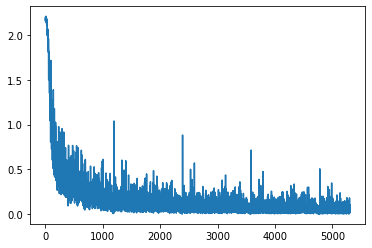

In [8]:
plt.plot(range(len(loss_log)), loss_log)
plt.show()

In [9]:
print(t_train.shape)
batch_size = 200
total_correct = 0

running_loss = 0.0
accuracy = 0.0
test_size = 1000
test_data_idx = np.random.choice(x_test.shape[0], test_size)
for i in tqdm(test_data_idx):
    x = x_test[i].reshape(1, 1, 28, 28)
    labels = t_test[i]

    outputs = model.forward(x)
    pred = ops.Softmax(outputs)
    labels = labels.reshape(pred.shape)
    c = (np.argmax(labels, 1) == np.argmax(pred, 1)).squeeze()
    total_correct += np.sum(c)

print(f"Accuracy:{total_correct/test_size}")


(60000, 10)


100%|██████████| 1000/1000 [00:09<00:00, 107.39it/s]

Accuracy:0.977
